# 안개 발생 진단 분류 모델 데이터셋 EDA

## 1. 데이터 설명

- 컬럼

    - `Year` : 년도
    - `Month` : 월
    - `Day` : 일
    - `Time` : 시간 (0 ~ 23)
    - `Minute` : 분 (10분 단위)
    - `STN_ID` : 지점 번호
    - `WS10(deg)` : 10분 평균 풍향, 단위: deg
    - `WS10(m/s)` : 10분 평균 풍속, 단위: m/s
    - `TA` : 1분 평균 기온 10분 주기, 단위: C
    - `RE` : 강수 유무 (0:무강수, 1:강수)
    - `HM` : 1분 평균 상대 습도 10분 주기, 단위: %
    - `sun10` : 1분 일사량 10분단위 합계, 단위: MJ
    - `TS` : 1분 평균 지면온도 10분 주기, 단위: C
    - `VIS1` : 1분 평균 시정 10분 주기, 단위: C (VIS1 변수는 시정 구간을 알 수 있는 변수로 검증 데이터에서는 제외)
    - `class` : 시정 구간

- 시정 계급 기준 (비고: 안개의 기준)

    - `1` : 0 < 시정 < 200
    - `2` : 200 <= 시정 < 500
    - `3` : 500 <= 시정 < 1000
    - `4` : 1000 <= 시정


## 2. 데이터 불러오기

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from matplotlib import rcParams


import os
import pickle

import warnings
warnings.filterwarnings(action='ignore')

# pd.set_option("float_format", "{:.4f}".format)
pd.set_option("display.max_columns", None)

In [2]:
plt.rc('font', family='NanumBarunGothic')
plt.rcParams['axes.unicode_minus'] = False

### 2-1 로컬 디렉토리 경로

In [3]:
# 작업 디렉토리 변경 (로컬 디렉토리에서 작업시 실행)

def get_local_path(train_dataset_name, test_dataset_name):

    # 작업 디렉토리 origin_dir에 선언
    origin_dir = os.getcwd()

    # ".." : 상위 디렉토리로 이동
    os.chdir("..")

    # 상위 디렉토리에 fog_data가 없다면 fog_data 폴더 생성
    # (이미 폴더 있어도 exist_ok=True면 넘어감)
    os.makedirs("fog_data", exist_ok=True)

    # train/test 데이터셋 경로 잡아준다
    train_path = os.path.join(os.getcwd(), "fog_data", train_dataset_name)
    test_path = os.path.join(os.getcwd(), "fog_data", test_dataset_name)

    # 운영체제가 윈도우일 경우, "\\"를 "/"로 바꿔줘야 한다
    if os.name == "nt":
        train_path = train_path.replace("\\", "/")
        test_path = test_path.replace("\\", "/")

    # origin_dir로 경로 다시 변경 (초기화)
    os.chdir(origin_dir)

    return train_path, test_path

In [4]:
train_path, test_path = get_local_path("fog_train.csv", "fog_test.csv")

### 2-2. colab 디렉토리 경로 (colab 작업시)

In [5]:
# # 구글 드라이브 파일 접근
# from google.colab import drive
# drive.mount('/content/drive')

In [6]:
# # colab 파일 경로 생성 함수
# # colab에서 작업시 주석 풀고 실행

# def get_colab_path(train_dataset_name, test_dataset_name):

#     fog_folder = "drive/MyDrive/weather_bigdata/fog_data"
#     os.makedirs(fog_folder, exist_ok=True)

#     # train/test 데이터셋 경로 잡아준다
#     train_path = os.path.join(os.getcwd(), fog_folder, train_dataset_name)
#     test_path = os.path.join(os.getcwd(), fog_folder, test_dataset_name)

#     return train_path, test_path

In [7]:
# train_path, test_path = get_colab_path("fog_train.csv", "fog_test.csv")

## 3. 데이터셋 및 전처리

In [8]:
train_df = pd.read_csv(train_path, index_col=0).rename(columns=lambda x: x.split('.')[1]).reset_index(drop=True)
test_df = pd.read_csv(test_path, index_col=0).rename(columns=lambda x: x.split('.')[1]).reset_index(drop=True)

In [9]:
train_df.head(3)

,year,month,day,time,minute,stn_id,ws10_deg,ws10_ms,ta,re,hm,sun10,ts,vis1,class
0,I,1,1,0,10,AA,0.0,0.0,-6.4,0.0,38.9,0.0,-2.8,20000,4
1,I,1,1,0,20,AA,0.0,0.0,-6.3,0.0,37.9,0.0,-2.7,20000,4
2,I,1,1,0,30,AA,0.0,0.0,-6.3,0.0,40.0,0.0,-2.6,20000,4


In [10]:
test_df.head(3)

,year,month,day,time,minute,stn_id,ws10_deg,ws10_ms,ta,re,hm,sun10,ts,class
0,L,1,1,0,0,AI,329.5,0.6,-2.5,0.0,87.5,0.0,-1.6,NaN
1,L,1,1,0,10,AI,321.8,1.2,-2.5,0.0,88.2,0.0,-1.6,NaN
2,L,1,1,0,20,AI,0.4,0.4,-2.5,0.0,88.6,0.0,-1.7,NaN


In [11]:
train_df[train_df.duplicated()]

,year,month,day,time,minute,stn_id,ws10_deg,ws10_ms,ta,re,hm,sun10,ts,vis1,class


In [12]:
test_df[test_df.duplicated()]

,year,month,day,time,minute,stn_id,ws10_deg,ws10_ms,ta,re,hm,sun10,ts,class


### 3-1. 컬럼 수정 및 제거 함수

In [13]:
# 컬럼 수정 및 제거 함수
def modify_columns(train_df, test_df):

    # stn_id 수정 : A, B, C, D, E로 수정
    train_df["stn_id"] = train_df["stn_id"].apply(lambda x: x[0])
    test_df["stn_id"] = test_df["stn_id"].apply(lambda x: x[0])

    # year, month, day, time, minute, 컬럼 drop
    # train_df.drop(columns=["year", "month", "day", "time", "minute", "vis1"], inplace=True)
    # test_df.drop(columns=["year", "month", "day", "time", "minute"], inplace=True)

    # hm = 0인 데이터 index 찾아서 drop
    hm_zero_idx = train_df[train_df['hm'] == 0].index
    train_df.drop(hm_zero_idx, inplace=True)

    # day, minute 컬럼 제거
    train_df.drop(columns=["day", "minute"], inplace=True)
    test_df.drop(columns=["day", "minute"], inplace=True)


    return train_df, test_df

In [14]:
train_df, test_df = modify_columns(train_df, test_df)

In [15]:
def make_ordinal(df, column):

    # 결측치 drop
    # df.dropna(inplace=True)
    
    # class 컬럼 순서형 변수로 변경
    df[column] = pd.Categorical(train_df[column],
                                categories=[-99, 1, 2, 3, 4],
                                ordered=True)

    return df

In [16]:
train_df = make_ordinal(train_df, "class")

### 3-2. 안개 여부 컬럼 생성 함수
- `class` = 4 : 안개 X (0)
- `class` <= 3 : 안개 O (1)

In [17]:
def is_fog(df, column):
    df["is_fog"] = df[column].apply(lambda x: 0 if x > 3 else 1)
    return df

In [18]:
train_df = is_fog(train_df, "class")

In [19]:
# class 컬럼 값 count
class_cnt = train_df["class"].value_counts().to_frame()

# class 컬럼 값 비율
class_pct = train_df["class"].value_counts(normalize=True).to_frame()

# 개수, 비율 concat
pd.concat([class_cnt, class_pct], axis=1).sort_index()

,count,proportion
class,,
-99,22516,0.007133
1,7866,0.002492
2,12088,0.003830
3,12180,0.003859
4,3101808,0.982686


### 3-3. 이슬점

#### 3-3-1. 이슬점 생성 함수

In [20]:
def calculate_dew_point(T, RH):
    # 이슬점 생성 함수
    # T : 기온, RH : 상대 습도

    # b = 17.27
    # c = 237.7
    b = 17.62
    c = 234.12

    gamma = (b * T) / (c + T) + np.log(RH / 100.0)
    dew_point = (c * gamma) / (b - gamma)

    return dew_point

In [21]:
train_df["dew_point"] = calculate_dew_point(train_df['ta'], train_df['hm'])
test_df["dew_point"] = calculate_dew_point(test_df['ta'], test_df['hm'])

#### 3-3-2. 이슬점 도달 여부 함수

In [22]:
def diff_ts_dew(df, ts, dew_point):
    # 기온 - 이슬점 <= 0, 이슬점 온도보다 기온이 낮다는 뜻
    df["dew_reached"] = df.apply(lambda x: 1 if (x[ts] - x[dew_point] <= 0) else 0, axis=1)

    return df       

In [23]:
train_df = diff_ts_dew(train_df, "ts", "dew_point")
test_df = diff_ts_dew(test_df, "ts", "dew_point")

### 3-4. 온도 차이 함수 (기온 - 지표면 온도)

In [24]:
def temp_diff(df):
    df["temp_diff"] = df["ta"] - df["ts"]
    return df

In [25]:
train_df = temp_diff(train_df)
test_df = temp_diff(test_df)

### 3-5. 풍향 수정
- `ws10_deg` 가 360인 것 → 0으로 변경

In [26]:
def switch_wind_degree(df, col):
    # 풍향 360인 것 0으로 변경
    df[col] = df[col].apply(lambda x: 0 if x==360 else x)
    return df

In [27]:
train_df = switch_wind_degree(train_df, "ws10_deg")

### 3-6. 결측치 치환 함수

In [28]:
# 결측치 처리하지 않은 train 데이터셋 copy
train_df_with_nan = train_df.copy()

In [29]:
# -99, -99.9인 데이터를 np.nan으로 치환하는 함수

def switch_to_nan(df):
    df = df.replace({-99:np.nan, -99.9:np.nan})    
    # train_df = train_df.replace({-99:np.nan, -99.9:np.nan})
    # test_df = test_df.replace({-99:np.nan, -99.9:np.nan})
    df.dropna(inplace=True)
    
    return df

In [30]:
train_df = switch_to_nan(train_df)

## 4. EDA

In [31]:
# 명목형 변수 값 확인
cat_col_names = train_df.select_dtypes(exclude=np.number).columns

for col_name in cat_col_names:
    cat_values = np.unique(train_df[col_name])
    print(f"{col_name}: {cat_values}\n")

year: ['I' 'J' 'K']

stn_id: ['A' 'B' 'C' 'D' 'E']

class: [1 2 3 4]



In [32]:
# 수치형 변수 최대, 최소값 확인
num_col_names = train_df.select_dtypes(include=np.number).columns

for col_name in num_col_names:
    print(f"{col_name}: ({train_df[col_name].min()}, {train_df[col_name].max()})")

month: (1, 12)
time: (0, 23)
ws10_deg: (0.0, 359.9)
ws10_ms: (0.0, 21.6)
ta: (-24.0, 37.8)
re: (0.0, 1.0)
hm: (2.4, 100.0)
sun10: (0.0, 26.87)
ts: (-4.9, 70.1)
vis1: (1.0, 60525.0)
is_fog: (0, 1)
dew_point: (-35.28120377067191, 29.86693717991899)
dew_reached: (0, 1)
temp_diff: (-43.1, 37.5)


In [33]:
train_df.describe()

,month,time,ws10_deg,ws10_ms,ta,re,hm,sun10,ts,vis1,is_fog,dew_point,dew_reached,temp_diff
count,2.994849e+06,2.994849e+06,2.994849e+06,2.994849e+06,2.994849e+06,2.994849e+06,2.994849e+06,2.994849e+06,2.994849e+06,2.994849e+06,2.994849e+06,2.994849e+06,2.994849e+06,2.994849e+06
mean,6.532855e+00,1.157743e+01,1.849109e+02,2.187701e+00,1.401094e+01,5.314191e-02,6.707400e+01,1.048124e-01,1.608666e+01,1.963091e+04,1.059185e-02,7.468118e+00,3.188875e-02,-2.075719e+00
std,3.382022e+00,6.891594e+00,1.064250e+02,1.752211e+00,9.747869e+00,2.243164e-01,2.105262e+01,1.594294e-01,1.210820e+01,1.191264e+04,1.023703e-01,1.120474e+01,1.757039e-01,5.048360e+00
min,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,-2.400000e+01,0.000000e+00,2.400000e+00,0.000000e+00,-4.900000e+00,1.000000e+00,0.000000e+00,-3.528120e+01,0.000000e+00,-4.310000e+01
25%,4.000000e+00,6.000000e+00,8.490000e+01,9.000000e-01,6.200000e+00,0.000000e+00,5.160000e+01,0.000000e+00,5.900000e+00,1.240000e+04,0.000000e+00,-1.196719e+00,0.000000e+00,-3.500000e+00
50%,7.000000e+00,1.200000e+01,2.079000e+02,1.800000e+00,1.470000e+01,0.000000e+00,6.910000e+01,1.000000e-02,1.630000e+01,2.000000e+04,0.000000e+00,7.498590e+00,0.000000e+00,-7.000000e-01
75%,9.000000e+00,1.800000e+01,2.759000e+02,3.000000e+00,2.220000e+01,0.000000e+00,8.500000e+01,1.700000e-01,2.460000e+01,2.000000e+04,0.000000e+00,1.744527e+01,0.000000e+00,1.000000e+00
max,1.200000e+01,2.300000e+01,3.599000e+02,2.160000e+01,3.780000e+01,1.000000e+00,1.000000e+02,2.687000e+01,7.010000e+01,6.052500e+04,1.000000e+00,2.986694e+01,1.000000e+00,3.750000e+01


### 4-1. 월별 안개 발생 분포 확인

In [34]:
# 안개가 발생한 것만 필터링하여 fog_yes_df에 선언
fog_yes_df = train_df.groupby(["month"])[["is_fog", "class"]].value_counts().to_frame()

In [35]:
# 월별 안개발생 빈도를 따로 groupby하여, fog_yes_total에 선언
fog_tot_num = train_df[train_df["is_fog"]==1].groupby(["month"])["class"].count().to_frame()
fog_tot_num = fog_tot_num.rename(columns={"class":"tot_cnts"}).reset_index()

In [36]:
,# season_df에서 안개가 낀 데이터만 가져옴
is_fog_df = fog_yes_df.reset_index()[(fog_yes_df.reset_index()["is_fog"] == 1) & (fog_yes_df.reset_index()["class"] != 4)]

# season 별 stn_id의 비율을 구하기 위해 season_fot_tot_num 데이터프레임과 merge
is_fog_df = is_fog_df.merge(fog_tot_num)

is_fog_df["fog_distribution"] = is_fog_df["count"] / is_fog_df["tot_cnts"]

# season, stn_id 컬럼 순으로 정렬
is_fog_df = is_fog_df.sort_values(["month", "class"])

# # proportion을 %로 만들어주고 소수 셋째자리에서 반올림
# is_fog_df["proportion"] = is_fog_df["proportion"].apply(lambda x: np.round(x*100, 2))

is_fog_df["fog_distribution"] = is_fog_df["fog_distribution"].apply(lambda x: np.round(x*100, 2))

In [37]:
is_fog_df

,month,is_fog,class,count,tot_cnts,fog_distribution
2,1,1,1,499,2492,20.02
1,1,1,2,747,2492,29.98
0,1,1,3,1246,2492,50.00
5,2,1,1,360,1873,19.22
4,2,1,2,502,1873,26.80
3,2,1,3,1011,1873,53.98
6,3,1,1,1048,2909,36.03
8,3,1,2,927,2909,31.87
7,3,1,3,934,2909,32.11
10,4,1,1,406,1204,33.72


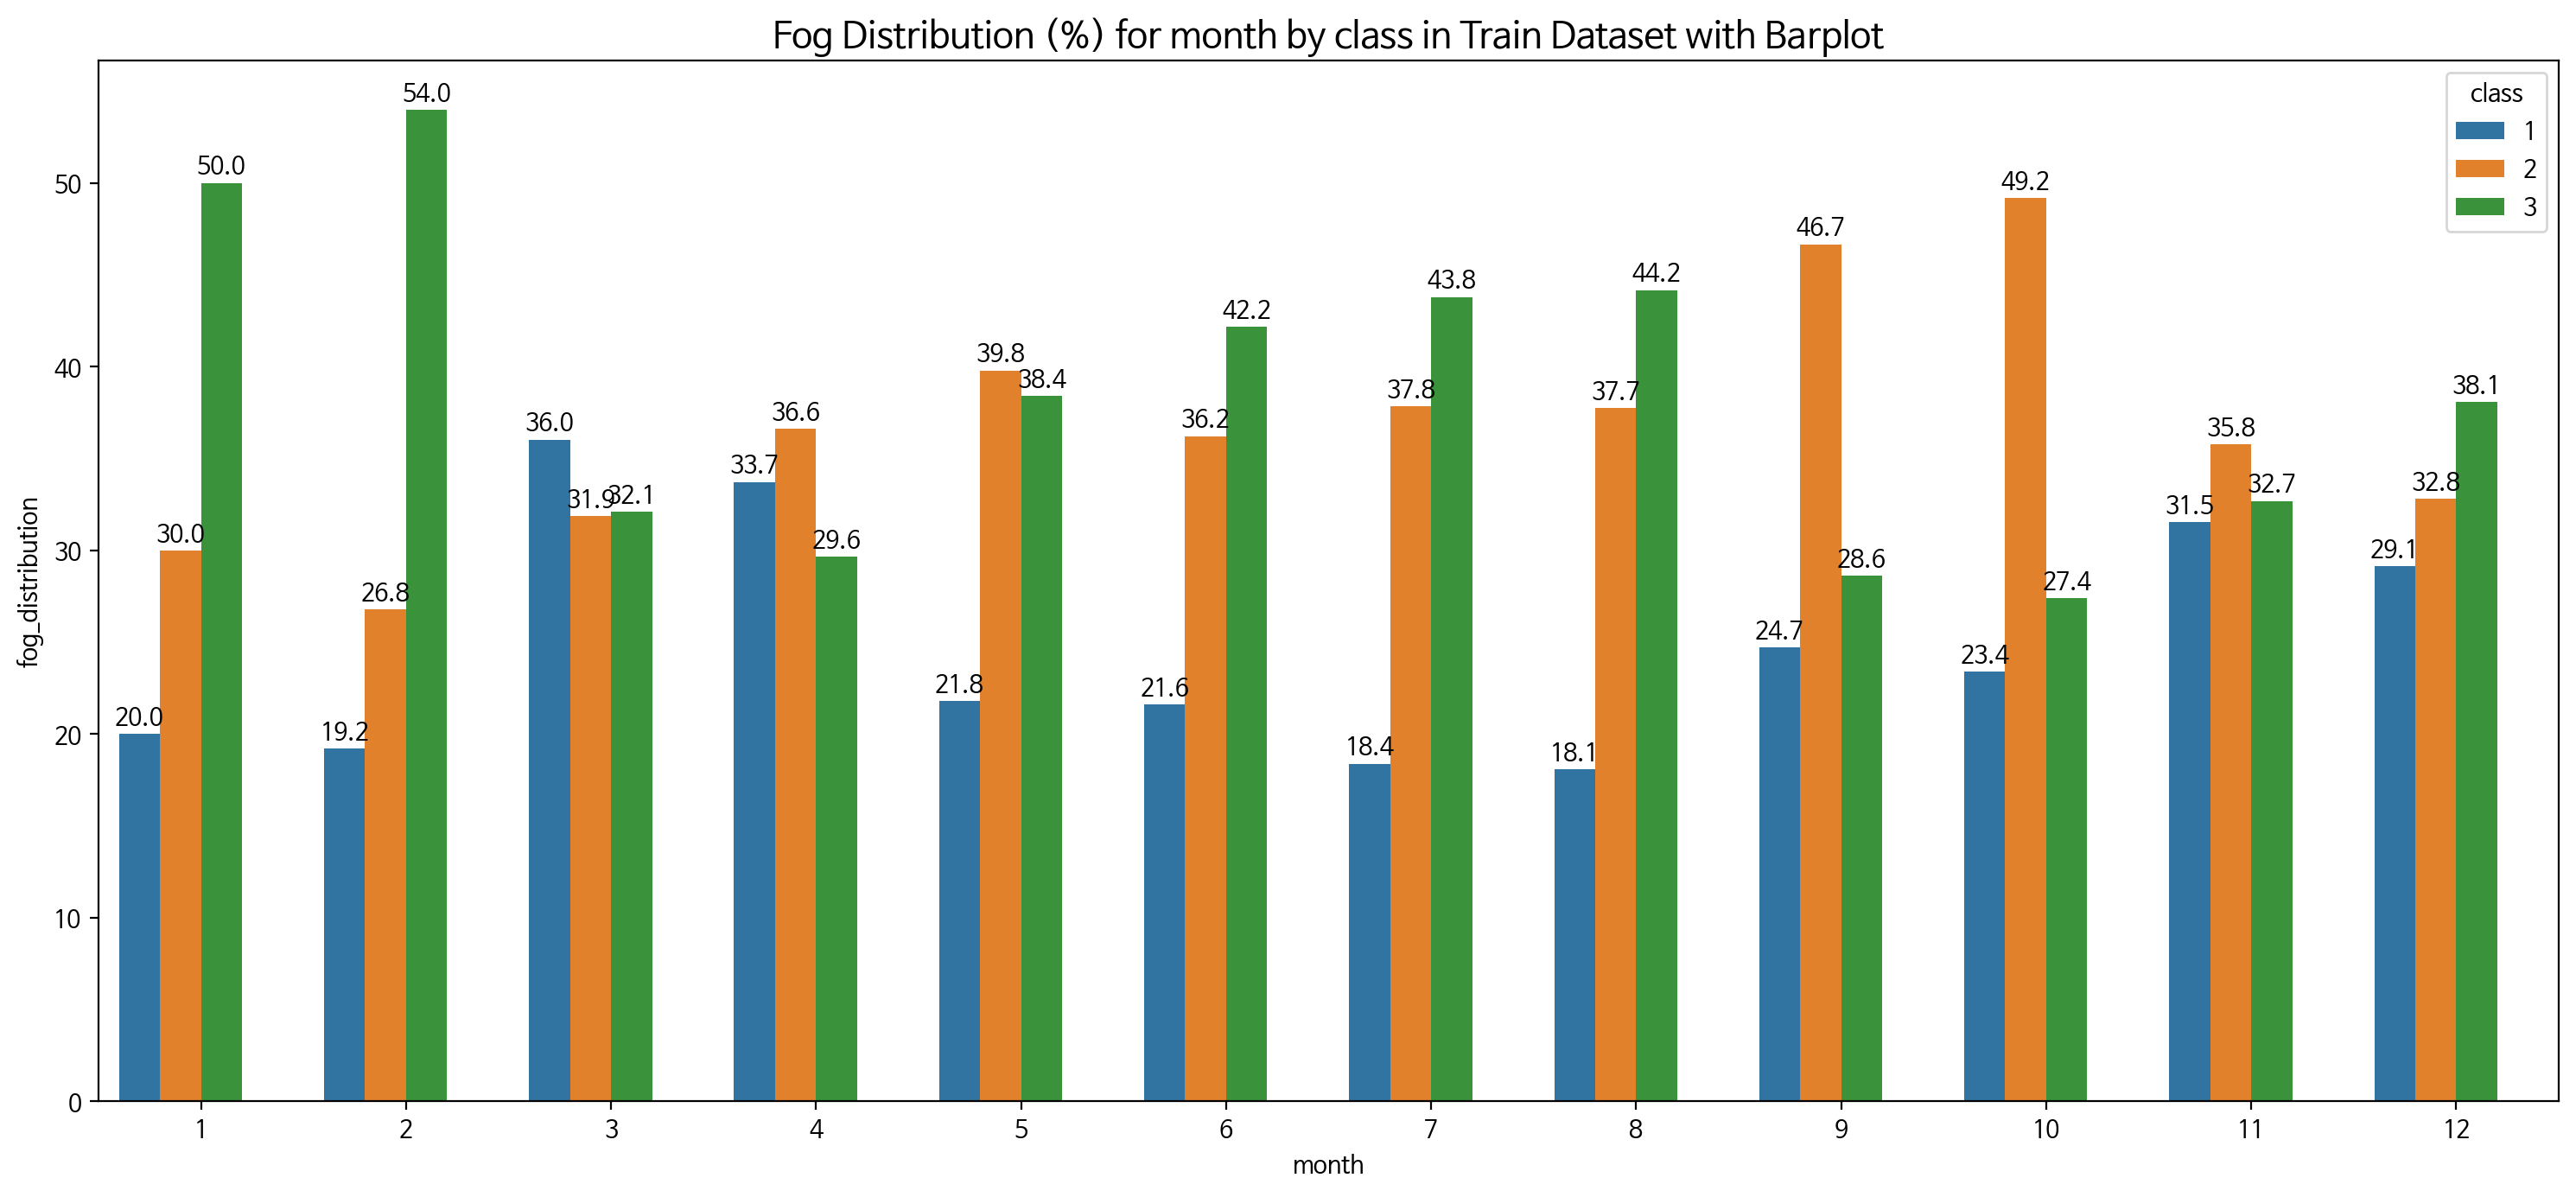

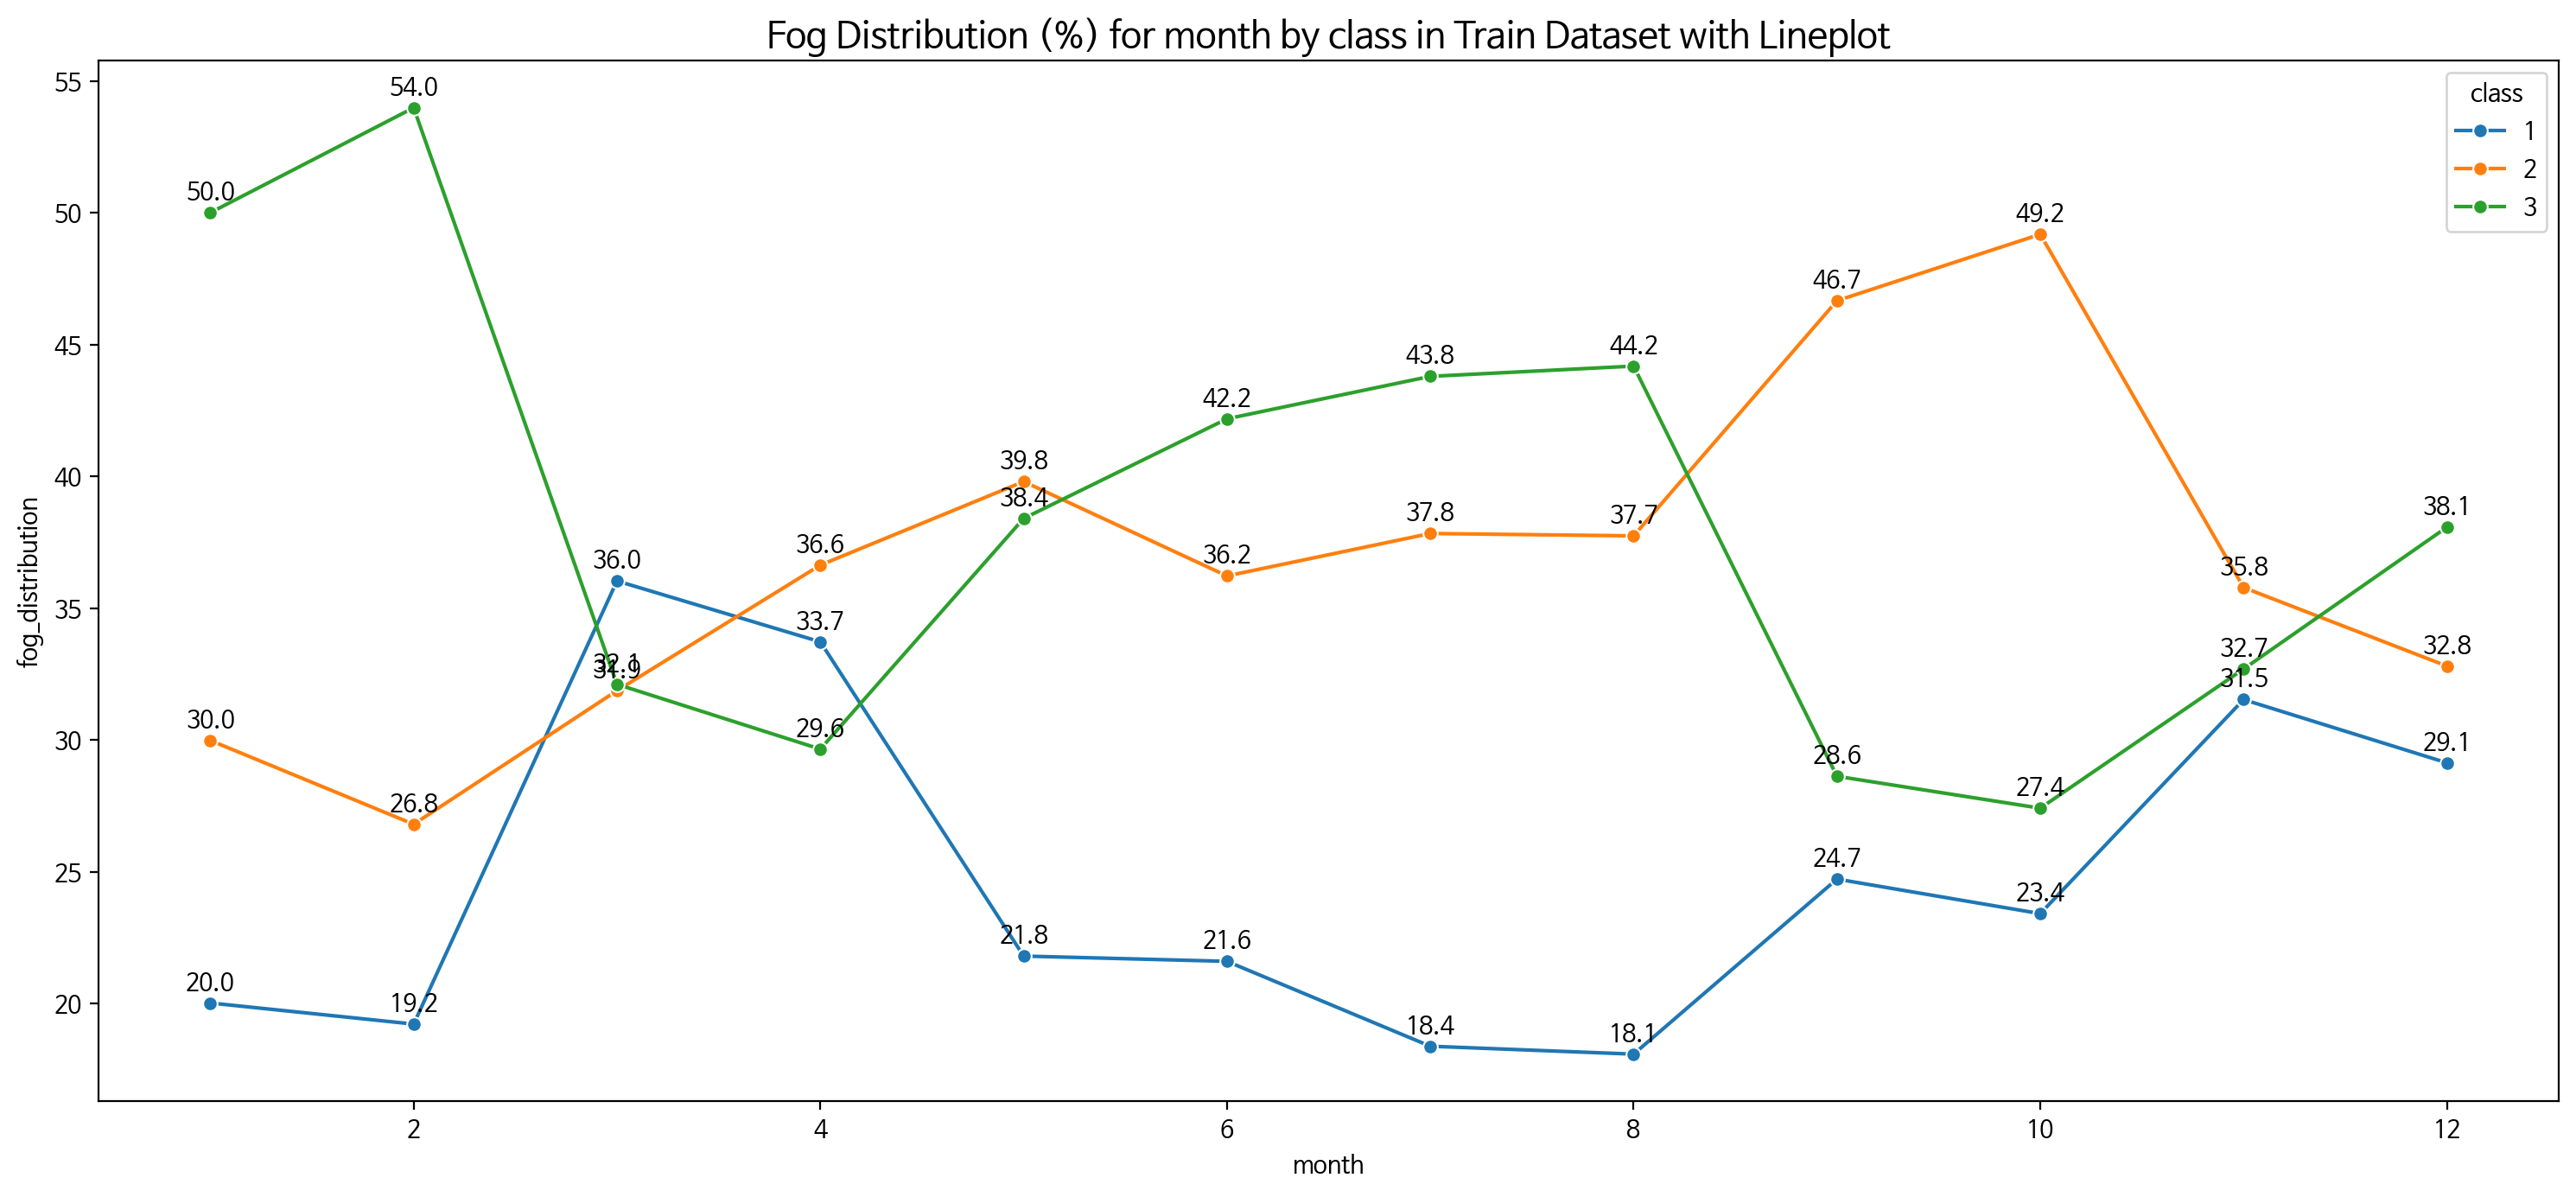

In [38]:
# class=4가 아닌 데이터만 선택
# filtered_data = fog_yes_group[fog_yes_group['class'] != 4]

plt.figure(figsize=(15, 7))

# 막대 그래프 생성
sns_pct = sns.barplot(x="month", 
                      y="fog_distribution", 
                      hue="class", 
                      data=is_fog_df)

# x축 레이블 회전
sns_pct.set_xticklabels(sns_pct.get_xticklabels(), 
                        # rotation=30
                        )

# 막대 그래프 상단에 비율 (%) 표기
# 각 x 좌표별로 높이를 저장
heights_by_x = {}

for bar in sns_pct.patches:
    height = bar.get_height()  # 막대의 높이 가져오기
    if height > 0:  # 높이가 0보다 클 때만 텍스트 추가
        x = bar.get_x() + bar.get_width() / 2  # 텍스트 위치 x좌표

        if x not in heights_by_x:
            heights_by_x[x] = []

        # 이전 높이값이 존재하면, 새로운 텍스트 위치를 조정
        if heights_by_x[x]:
            previous_heights = sorted(heights_by_x[x], reverse=True)
            # 이전 텍스트와 현재 막대 사이의 최소 간격 설정
            offset = height + 0.5
            for prev_height in previous_heights:
                if abs(prev_height - offset) < 0.5:
                    offset = prev_height + 0.5
        else:
            offset = height + 0.5

        plt.text(x,  # 텍스트 위치 x좌표
                 offset,  # 텍스트 위치 y좌표
                 "%.1f" % height,  # 소수점 둘째 자리까지 비율 표시
                 ha="center")  # 가운데 정렬

        heights_by_x[x].append(offset)

# 불필요한 범례 항목 제거
handles, labels = sns_pct.get_legend_handles_labels()
filtered_handles = [handle for handle, label in zip(handles, labels) if label != '4']
filtered_labels = [label for label in labels if label != '4']

# 시각화 제목과 폰트 크기 지정
sns_pct.set_title("Fog Distribution (%) for month by class in Train Dataset with Barplot", fontsize=15)
sns_pct.legend(filtered_handles, filtered_labels, title='class')

plt.tight_layout()
# plt.show()


# lineplot 생성
plt.figure(figsize=(15, 7))

# 라인 플롯 생성
sns_pct = sns.lineplot(x="month", 
                      y="fog_distribution", 
                      hue="class", 
                      data=is_fog_df,
                      marker='o')  # 포인트에 마커 추가

# 라인 플롯의 각 포인트에 값 표시
for line in sns_pct.lines:
    for x, y in zip(line.get_xdata(), line.get_ydata()):
        if y > 0:  # 높이가 0보다 클 때만 텍스트 추가
            plt.text(x, y + 0.5, f"{y:.1f}", ha="center")

# 불필요한 범례 항목 제거
handles, labels = sns_pct.get_legend_handles_labels()
filtered_handles = [handle for handle, label in zip(handles, labels) if label != '4']
filtered_labels = [label for label in labels if label != '4']

# 시각화 제목과 폰트 크기 지정
sns_pct.set_title("Fog Distribution (%) for month by class in Train Dataset with Lineplot", fontsize=15)
sns_pct.legend(filtered_handles, filtered_labels, title='class')

plt.tight_layout()
plt.show()



#### 4-1-1. 결론
- 계절별로 안개 발생 class가 다르게 나타났다 <br>
 <br>
    - 봄 (3-5) : 비교적 고른 분포 
     
    - 여름 (6-8) : class 2, 3이 주로 발생  
     
    - 가을 (9-11)
    
        - class 2가 주로 발생
        - 여름에 비해 class 1도 증가
        - class=3은 여름에 비해 대폭 감소 
     
     - 겨울 (12-2)
        - 가을에 비해, 다시 class 3이 증가
        - class 1, 2는 다시 감소하는 추세

### 4-2. 월별, 관측소별 안개 발생 빈도 분포

In [39]:
# 월별, 관측소별 안개 유무 카운팅
month_df = train_df.groupby(["month", "stn_id"])["is_fog"].value_counts().to_frame()
month_df.unstack()

count      
is_fog             0     1
month stn_id              
1     A        91728   917
      B        35595   724
      C        23866    73
      D        35664   585
      E        38278   193
2     A        90029   514
      B        39049   390
      C        23259   127
      D        33403   629
      E        35030   213
3     A       104589   695
      B        51665   804
      C        26415   137
      D        38557   875
      E        39384   398
4     A       101779    95
      B        50730   476
      C        25647   103
      D        38119   370
      E        38133   160
5     A       105252   231
      B        52063   809
      C        26257   223
      D        39261   474
      E        38979   263
6     A       100452   272
      B        49706   894
      C        25440   104
      D        37359   839
      E        37496   409
7     A       103838   538
      B        50647  1527
      C        26214   240
      D        38948   531
      E        38234   500
8     A       102767   531
      B        51075  1180
      C        25410   203
      D        38313   460
      E        39558   204
9     A       102077   307
      B        48515  2245
      C        21224   251
      D        37604   715
      E        38596    78
10    A       102058   399
      B        50029  2883
      C        21944   172
      D        39557   301
      E        39324    25
11    A       100349   905
      B        48661  1468
      C        21444    63
      D        37827   704
      E        37328    57
12    A        94424   994
      B        37025   565
      C        21656    53
      D        36893   375
      E        38405   251

In [40]:
# 월별 안개가 낀 빈도수 계산하여 month_fog_tot_num에 선언
month_fog_tot_num = train_df[train_df["is_fog"]==1].groupby(["month"])["stn_id"].count().to_frame()
month_fog_tot_num = month_fog_tot_num.rename(columns={"stn_id":"tot_cnts"}).reset_index()

In [41]:
,# month_df에서 안개가 낀 데이터만 가져옴
month_is_fog = month_df.reset_index()[month_df.reset_index()["is_fog"] == 1]

# month 별 stn_id의 비율을 구하기 위해 month_fot_tot_num 데이터프레임과 merge
month_is_fog = month_is_fog.merge(month_fog_tot_num)

month_is_fog["stn_rate"] = month_is_fog["count"] / month_is_fog["tot_cnts"]


# month, stn_id 컬럼 순으로 정렬
month_is_fog = month_is_fog.sort_values(["month", "stn_id"])

month_is_fog["stn_rate"] = month_is_fog["stn_rate"].apply(lambda x: np.round(x*100, 2))

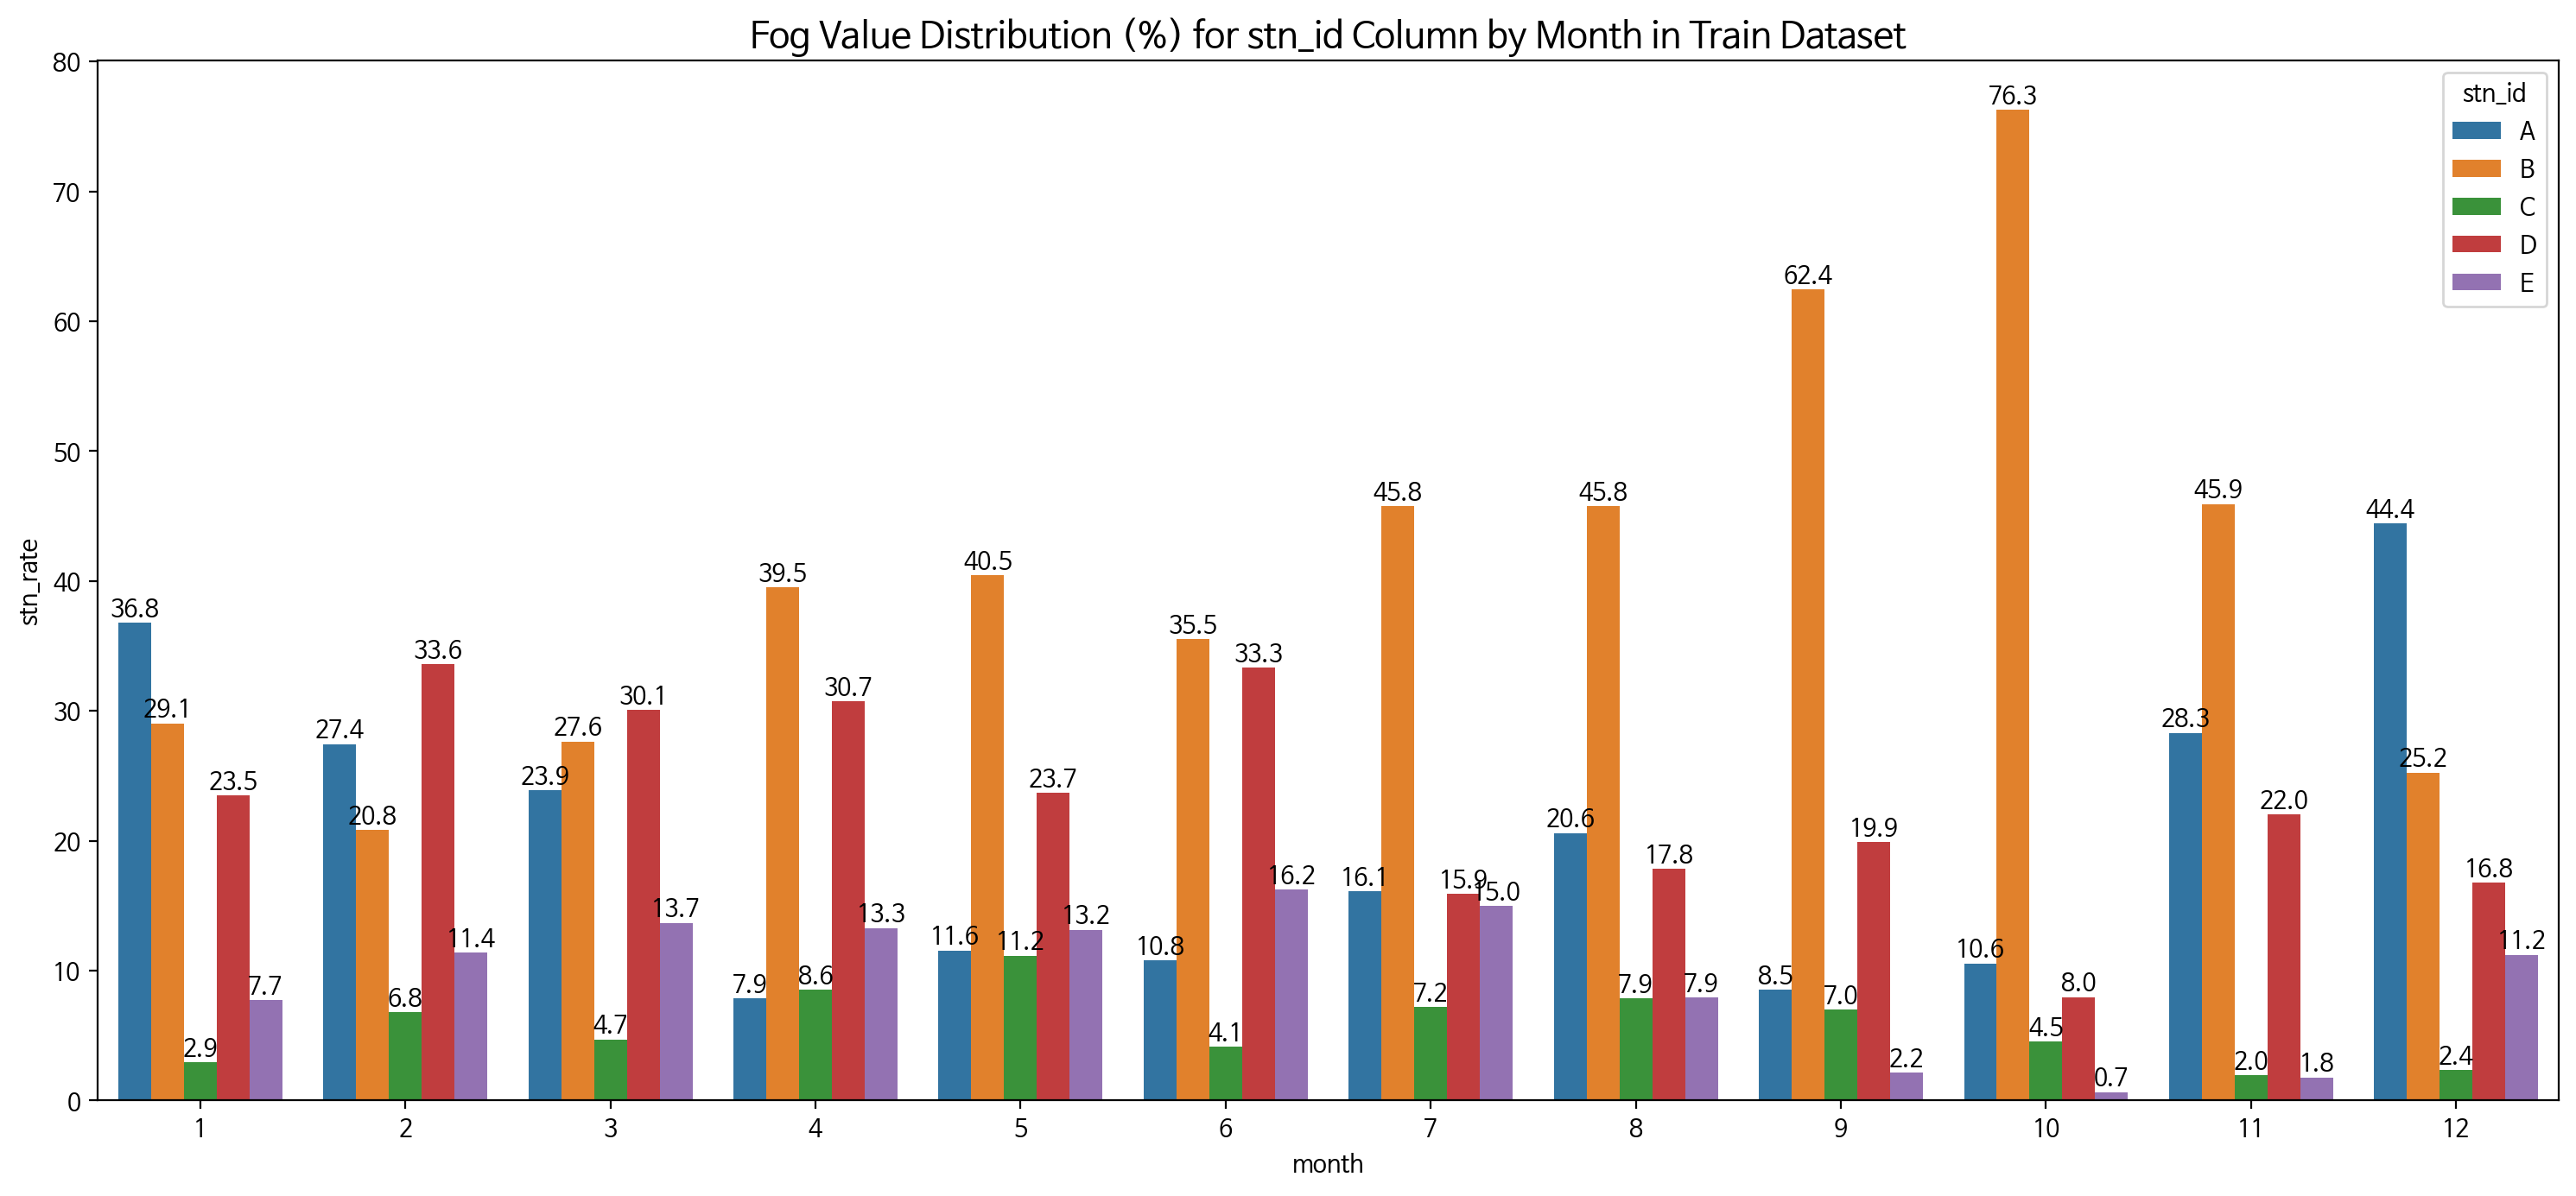

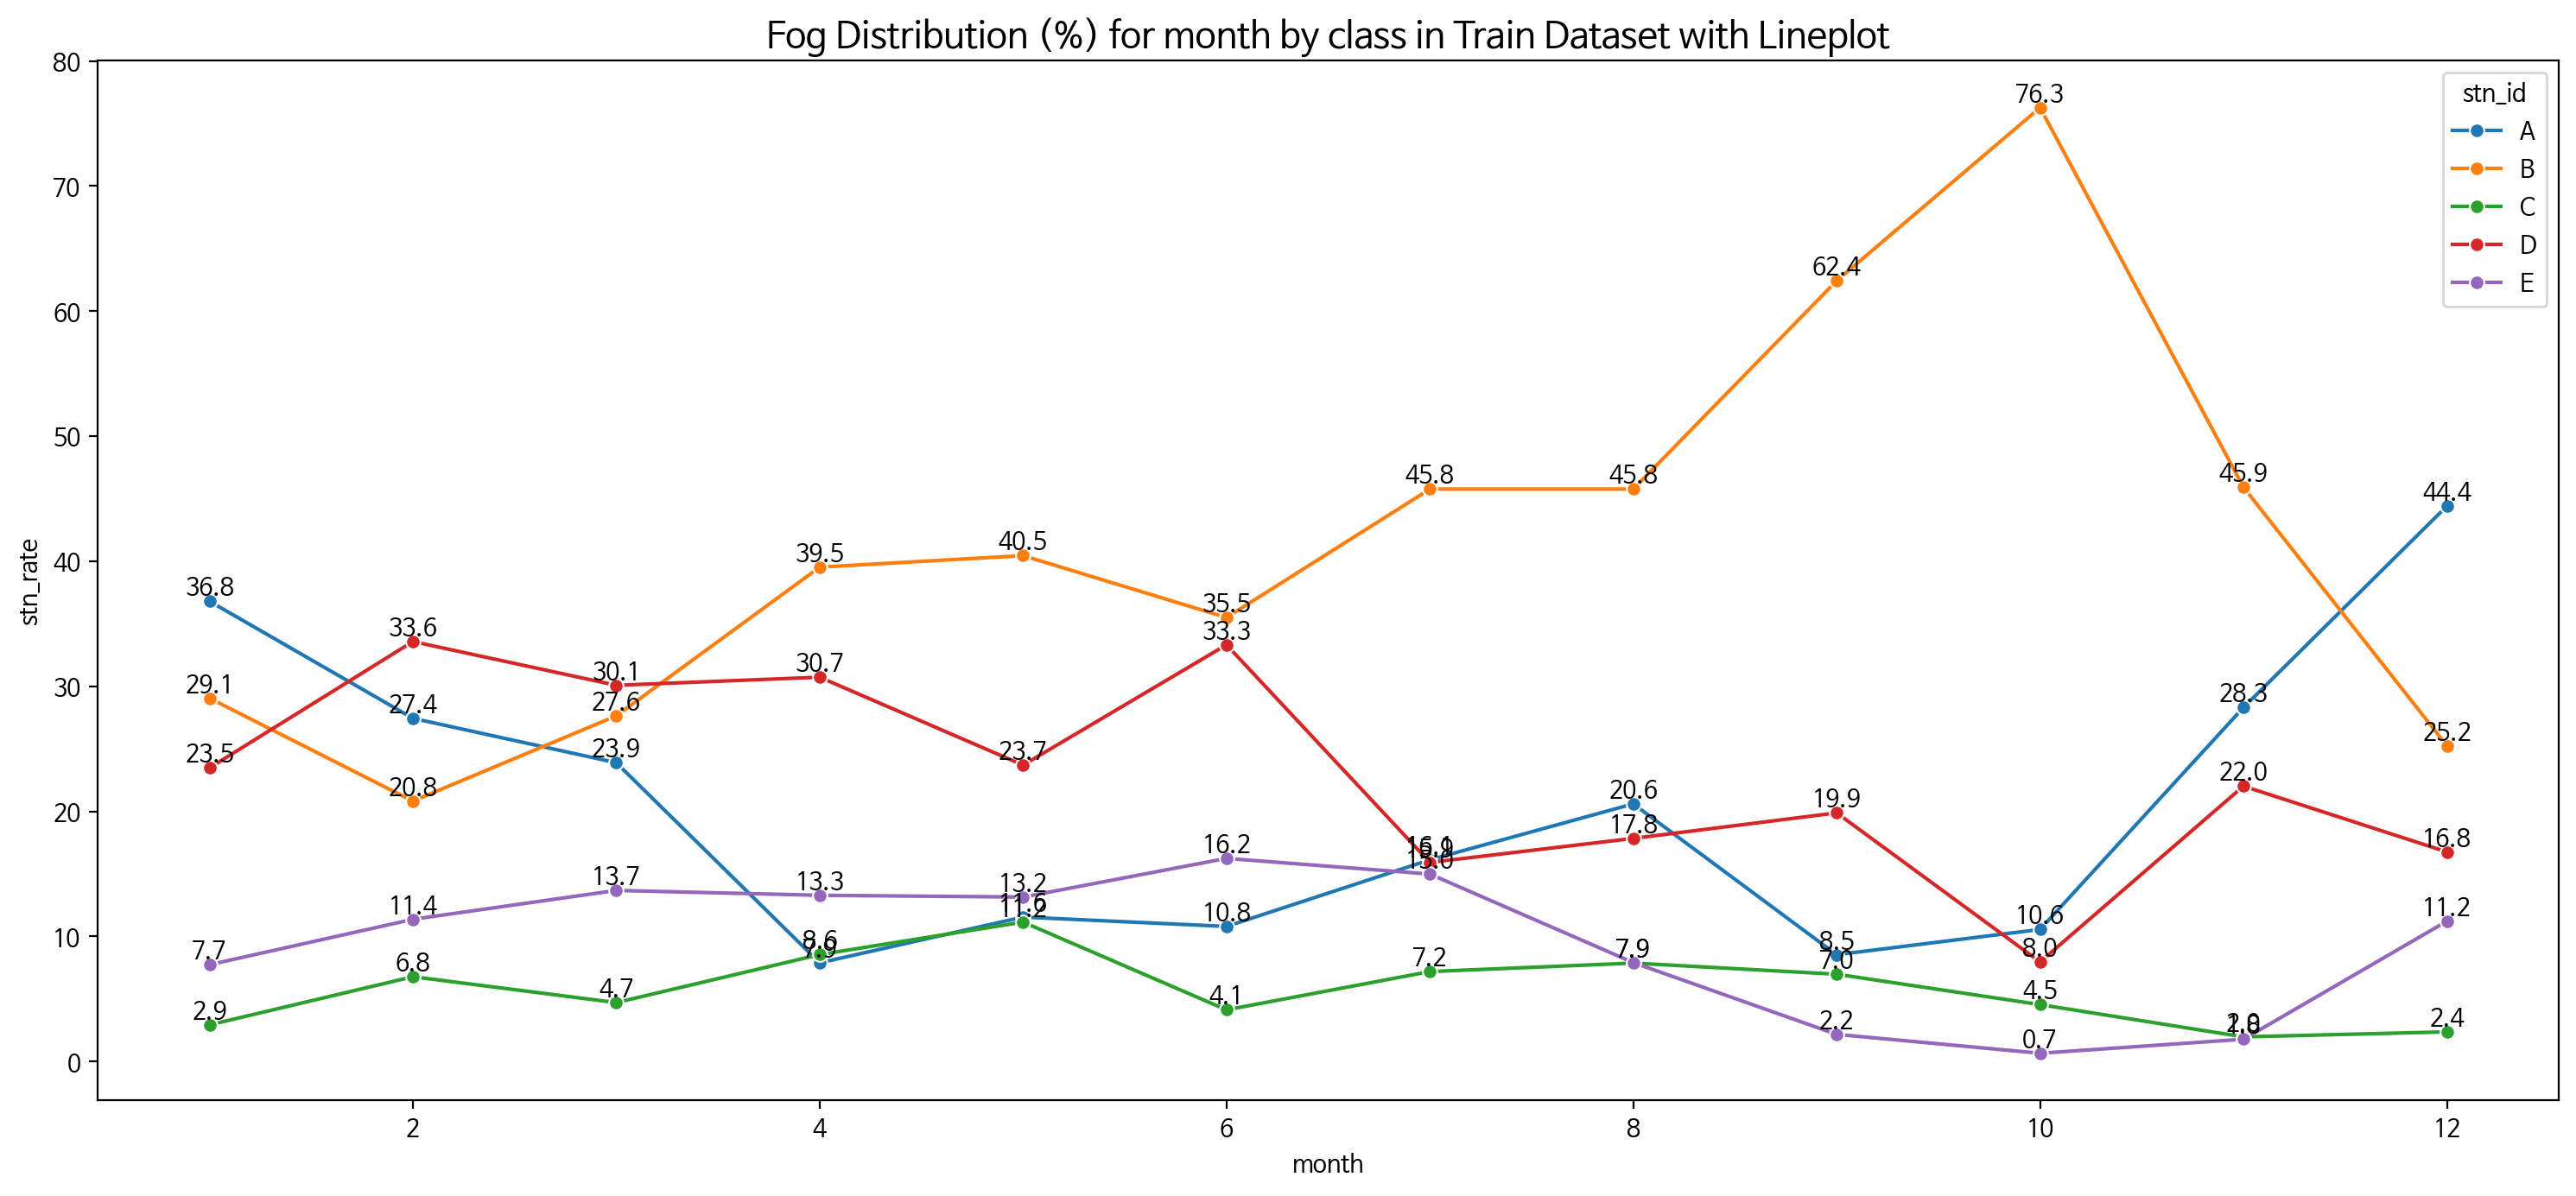

In [42]:
# 결측치 비율 시각화
plt.figure(figsize=(15, 7))

sns_pct = sns.barplot(x="month", 
                      y="stn_rate", 
                      hue="stn_id", 
                      data=month_is_fog)
                    #   data=np.round(is_fog_df * 100, 2).sort_values(["stn_id", "proportion"], ascending=[True, False]))


# sns_pct.set_xticklabels(sns_pct.get_xticklabels(), rotation=30)

# bar 그래프 상단에 비율 (%) 표기
for bar in sns_pct.patches:
    height = bar.get_height()                      # bar의 높이를 가져옴
    if height > 0:                                 # 높이가 0보다 클 때만 텍스트를 추가
        plt.text(bar.get_x() + bar.get_width()/2,  # 글자 위치 x좌표
                 height + 0.5,                   # 글자 위치 y좌표
                 "%.1f" % height,                  # 소수점 셋째 자리까지 비율 표시
                 ha="center")                      # 가운데 정렬


# 시각화 제목 이름, 폰트 크기 지정
sns_pct.set_title("Fog Value Distribution (%) for stn_id Column by Month in Train Dataset", fontsize=15)
plt.tight_layout()
# plt.show()


# lineplot 생성
plt.figure(figsize=(15, 7))

# 라인 플롯 생성
sns_pct = sns.lineplot(x="month", 
                      y="stn_rate", 
                      hue="stn_id", 
                      data=month_is_fog,
                      marker='o')  # 포인트에 마커 추가

# 라인 플롯의 각 포인트에 값 표시
for line in sns_pct.lines:
    for x, y in zip(line.get_xdata(), line.get_ydata()):
        if y > 0:  # 높이가 0보다 클 때만 텍스트 추가
            plt.text(x, y + 0.5, f"{y:.1f}", ha="center")

# 불필요한 범례 항목 제거
handles, labels = sns_pct.get_legend_handles_labels()
filtered_handles = [handle for handle, label in zip(handles, labels) if label != '4']
filtered_labels = [label for label in labels if label != '4']

# 시각화 제목과 폰트 크기 지정
sns_pct.set_title("Fog Distribution (%) for month by class in Train Dataset with Lineplot", fontsize=15)
sns_pct.legend(filtered_handles, filtered_labels, title='stn_id')

plt.tight_layout()
plt.show()

#### 4-2-1. 결론
- 안개 점유율

    - A 관측소 : 3월부터 낮아졌다가 10월부터 증가
    
    - B 관측소 : 8월 이후 높아졌다가 11월부터 2월까지 감소
    - C 관측소 : 전체적으로 저조, 3월부터 5월까지 소폭 증가
    - D 관측소 : 6월부터 8월까지 감소
    - E 관측소 : 7월부터 11월까지 감소, 이후 증가 추세 <br>
<br>
- 가을, 겨울에 내륙에서 안개가 더 많이 발생한다는 점에서, **A**, **B**는 내륙에 위치할 가능성이 크다

    - A, B는 10 ~ 12월 정반대 추세를 보인다
    
    - 11월에 서로 역전된다


### 4-3 이상치 확인 (temp_diff 컬럼 기준)

#### 4-3-1. 이상치 시각화

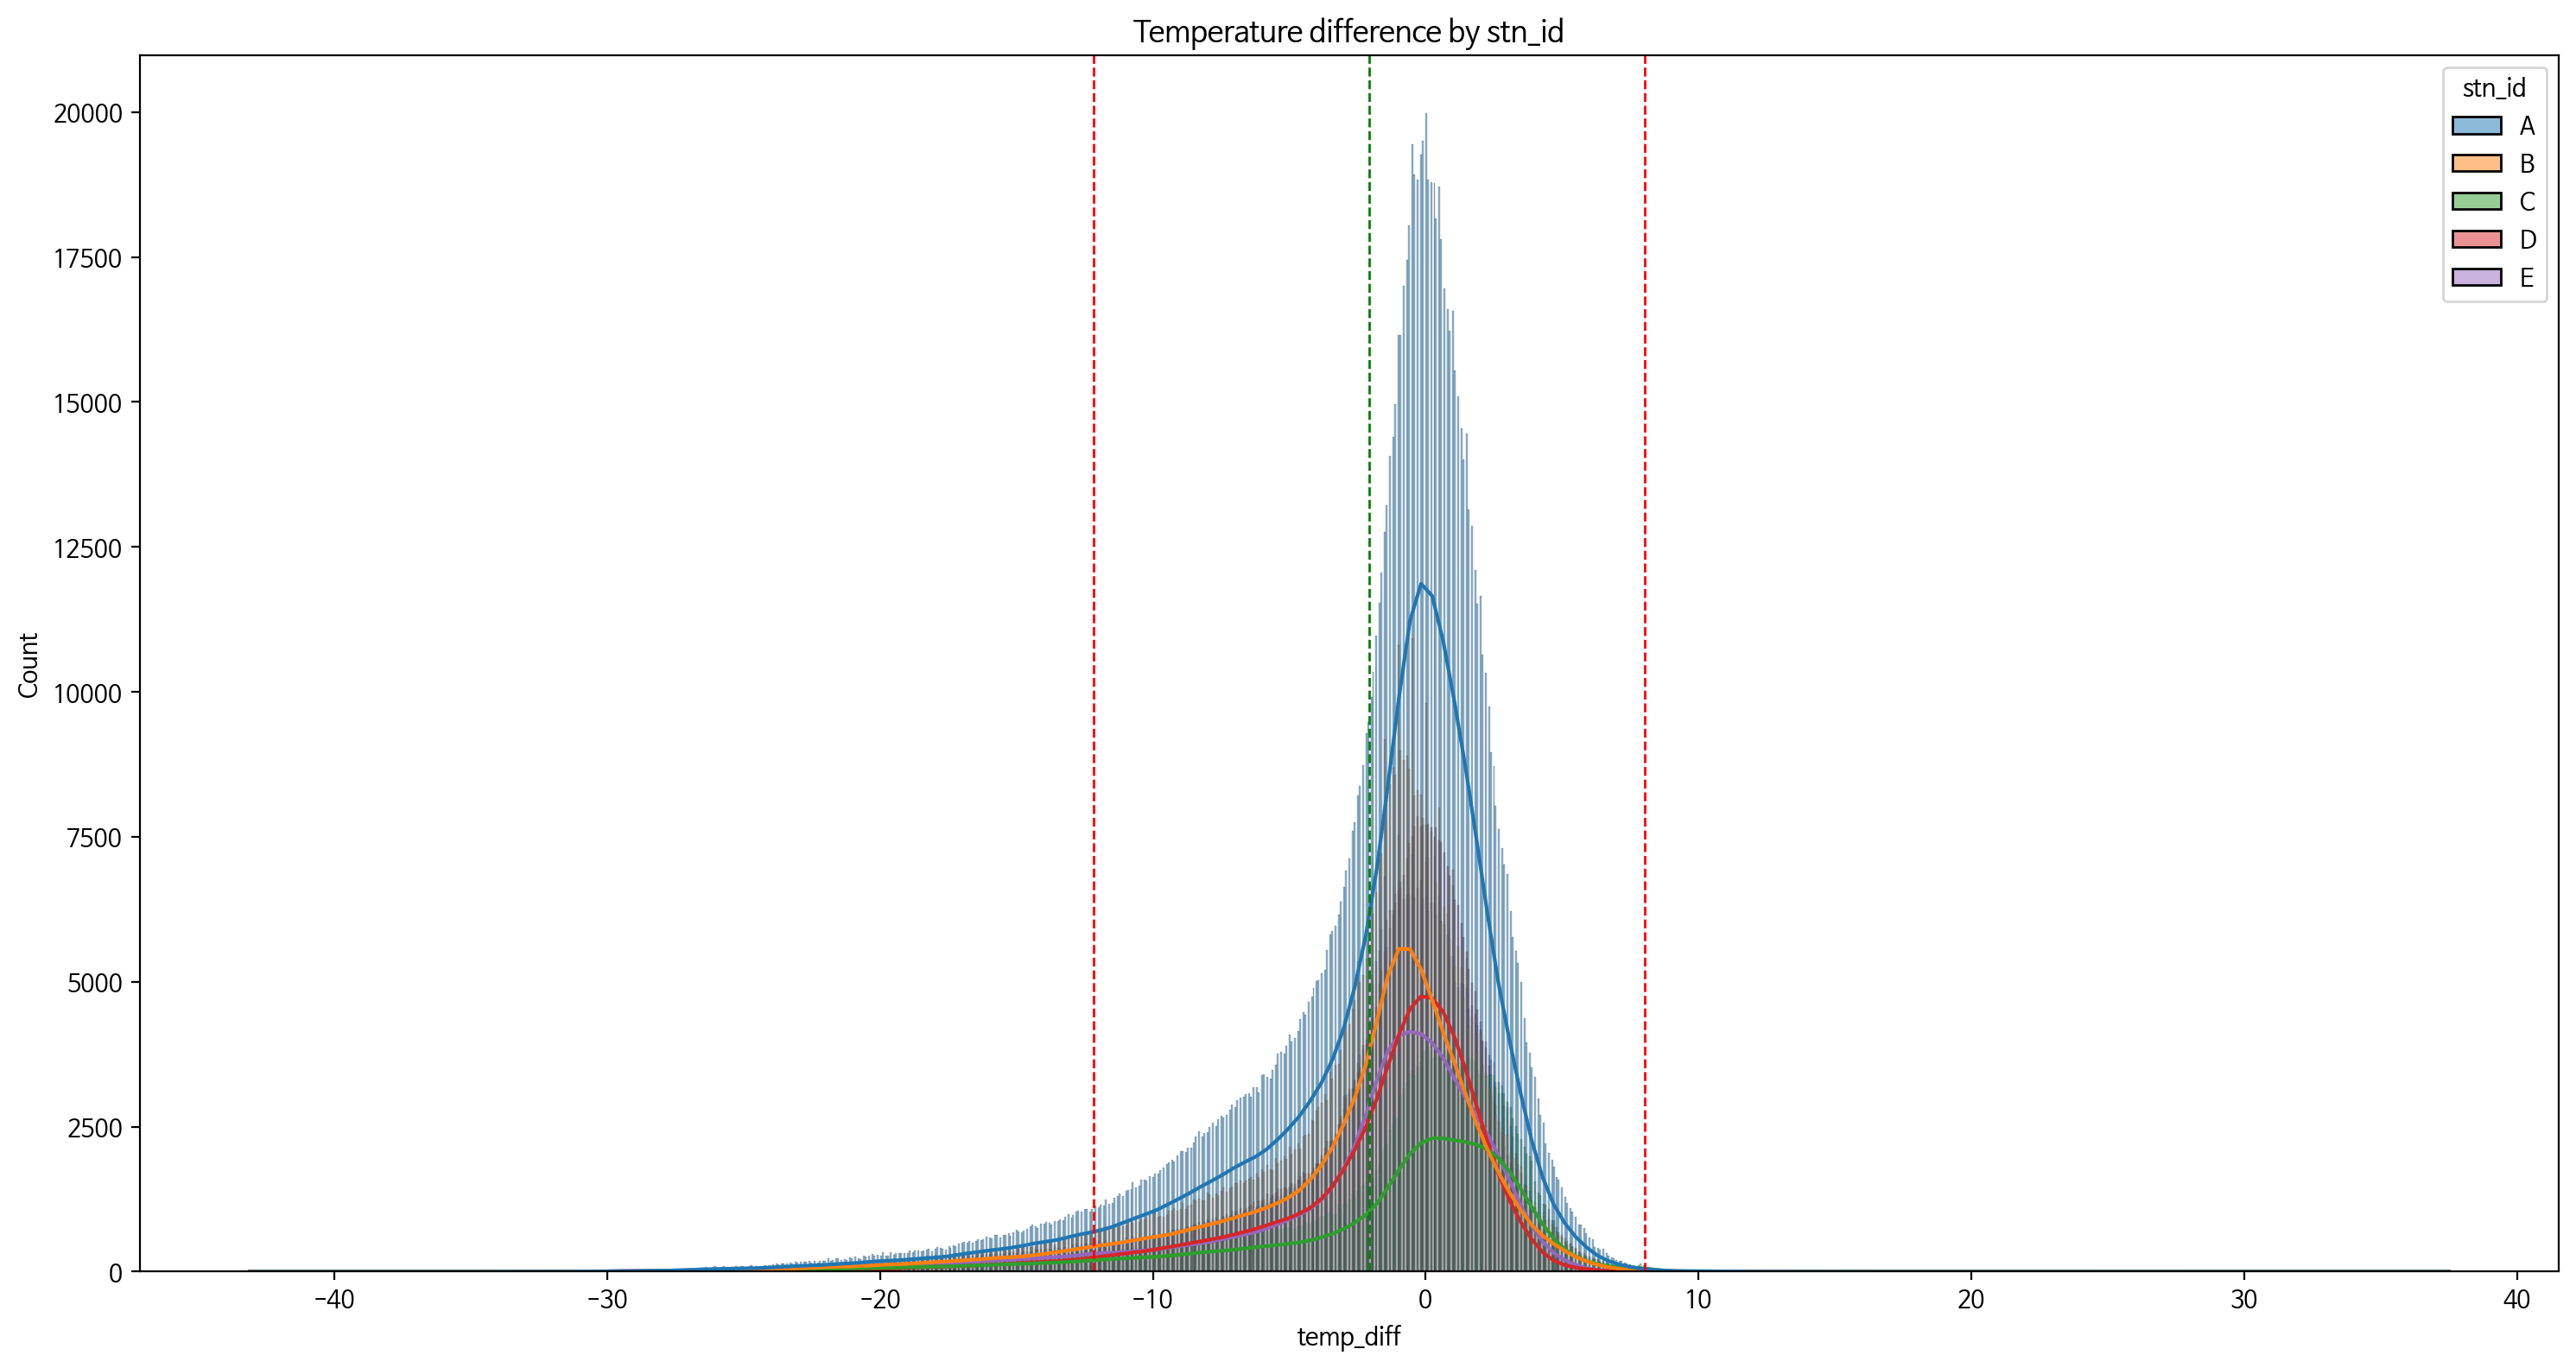

In [43]:
# 표준편차 기준 -2~2 범위 계산
std_minus_2 = np.mean(train_df["temp_diff"]) - 2 * np.std(train_df["temp_diff"])
std_plus_2 = np.mean(train_df["temp_diff"]) + 2 * np.std(train_df["temp_diff"])

plt.figure(figsize=(15, 8))

# 히스토그램 생성
sns.histplot(data=train_df, x="temp_diff", kde=True, hue="stn_id")

# 평균선 추가
plt.axvline(np.mean(train_df["temp_diff"]), color='g', linestyle='--', linewidth=1, label='Mean')

# 표준편차 기준 -2~2 범위선 추가
plt.axvline(std_minus_2, color='r', linestyle='--', linewidth=1, label='-2 Std Dev')
plt.axvline(std_plus_2, color='r', linestyle='--', linewidth=1, label='+2 Std Dev')


plt.title("Temperature difference by stn_id")
plt.tight_layout()

plt.show()

#### 4-3-2. 이상치 제거
- 표준편차 기준 -2~2 범위로 이상치 판단

In [44]:
# 이상치 제거 함수
# https://devhwi.tistory.com/11
# https://blog.naver.com/mbmb7777/222365280656
# https://blog.deeplink.kr/?p=2528

def outlier_remove(data, column, threshold=2):
    # Z-score 계산
    data["diff_z_scores"] = np.abs(data[column] - np.mean(data[column])) / np.std(data[column]) 
    
    filtered_data = data[data["diff_z_scores"] <= threshold]
    outlier = data[data["diff_z_scores"] > threshold]
    
    return filtered_data, outlier

In [45]:
# 이상치 제거한 데이터프레임 train_no_outlier_df에 선언
train_no_outlier_df, outlier_df = outlier_remove(train_df, "temp_diff")
train_no_outlier_df.head(3)

,year,month,time,stn_id,ws10_deg,ws10_ms,ta,re,hm,sun10,ts,vis1,class,is_fog,dew_point,dew_reached,temp_diff,diff_z_scores
0,I,1,0,A,0.0,0.0,-6.4,0.0,38.9,0.0,-2.8,20000.0,4,0,-17.680941,0,-3.6,0.301936
1,I,1,0,A,0.0,0.0,-6.3,0.0,37.9,0.0,-2.7,20000.0,4,0,-17.886195,0,-3.6,0.301936
2,I,1,0,A,0.0,0.0,-6.3,0.0,40.0,0.0,-2.6,20000.0,4,0,-17.273211,0,-3.7,0.321744


In [46]:
outlier_df.head(3)

,year,month,time,stn_id,ws10_deg,ws10_ms,ta,re,hm,sun10,ts,vis1,class,is_fog,dew_point,dew_reached,temp_diff,diff_z_scores
9290,I,3,12,A,336.2,2.1,3.8,0.0,33.0,0.47,16.2,15780.0,4,0,-10.498779,0,-12.4,2.045077
9291,I,3,12,A,294.9,2.3,4.2,0.0,31.3,0.47,16.9,19995.0,4,0,-10.786772,0,-12.7,2.104502
9293,I,3,13,A,219.0,3.2,4.6,0.0,32.3,0.47,17.5,20000.0,4,0,-10.053435,0,-12.9,2.144119


In [47]:
print("이상치 처리 전 Train 데이터셋 shape:", train_df.shape)

이상치 처리 전 Train 데이터셋 shape: (2994849, 18)


In [48]:
print("Train 데이터 Outlier 제거 :",  train_df.shape[0] - train_no_outlier_df.shape[0], "개")

Train 데이터 Outlier 제거 : 168725 개


In [49]:
print("이상치 처리 후 Train 데이터셋 shape:", train_no_outlier_df.shape)

이상치 처리 후 Train 데이터셋 shape: (2826124, 18)


### 4-4. 컬럼별 시각화

#### 4-4-1. 수치형 변수

In [50]:
num_cols = train_no_outlier_df.select_dtypes(include=np.number).columns
# 수치형 변수 중, vis1 컬럼은 제거 예정
print(num_cols)
print(len(num_cols),"개")

Index(['month', 'time', 'ws10_deg', 'ws10_ms', 'ta', 're', 'hm', 'sun10', 'ts',
       'vis1', 'is_fog', 'dew_point', 'dew_reached', 'temp_diff',
       'diff_z_scores'],
      dtype='object')
15 개


In [51]:
train_no_outlier_df

,year,month,time,stn_id,ws10_deg,ws10_ms,ta,re,hm,sun10,ts,vis1,class,is_fog,dew_point,dew_reached,temp_diff,diff_z_scores
0,I,1,0,A,0.0,0.0,-6.4,0.0,38.9,0.0,-2.8,20000.0,4,0,-17.680941,0,-3.6,0.301936
1,I,1,0,A,0.0,0.0,-6.3,0.0,37.9,0.0,-2.7,20000.0,4,0,-17.886195,0,-3.6,0.301936
2,I,1,0,A,0.0,0.0,-6.3,0.0,40.0,0.0,-2.6,20000.0,4,0,-17.273211,0,-3.7,0.321744
3,I,1,0,A,27.8,0.4,-6.2,0.0,39.5,0.0,-2.6,20000.0,4,0,-17.326023,0,-3.6,0.301936
4,I,1,0,A,59.7,0.5,-6.1,0.0,39.8,0.0,-2.5,20000.0,4,0,-17.149239,0,-3.6,0.301936
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3156454,K,12,23,E,305.3,7.7,2.5,0.0,50.2,0.0,-0.9,20000.0,4,0,-6.497846,0,3.4,1.084653
3156455,K,12,23,E,293.8,5.7,2.3,0.0,50.1,0.0,-1.3,20000.0,4,0,-6.707932,0,3.6,1.124270
3156456,K,12,23,E,274.2,4.9,2.2,0.0,51.0,0.0,-1.4,20000.0,4,0,-6.577210,0,3.6,1.124270
3156457,K,12,23,E,270.3,4.6,2.1,0.0,51.7,0.0,-1.6,20000.0,4,0,-6.498834,0,3.7,1.144078


#### 4-4-2. 명목형 변수

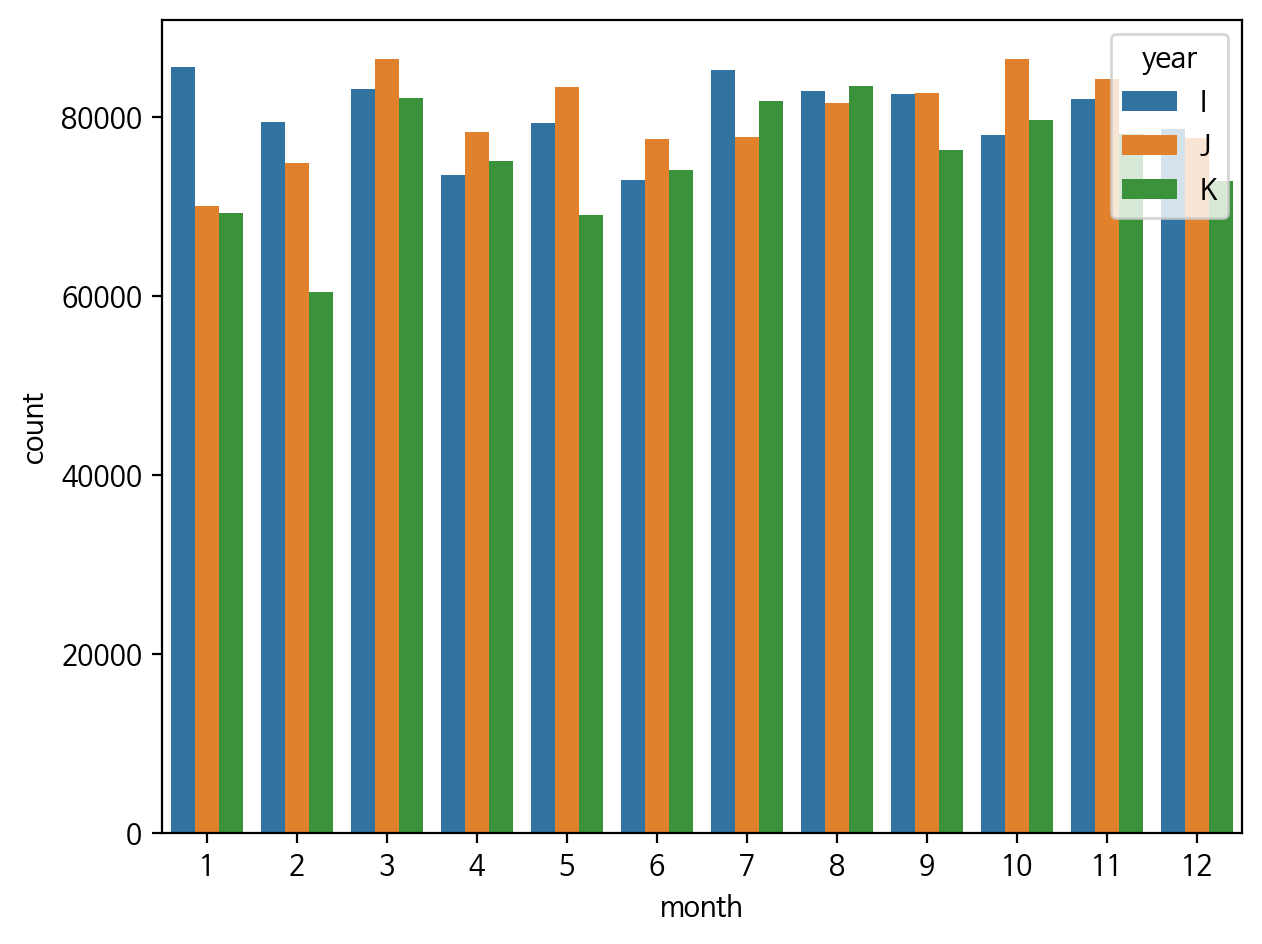

In [52]:
sns.countplot(data=train_no_outlier_df, x="month", hue="year")
plt.tight_layout()
plt.show()

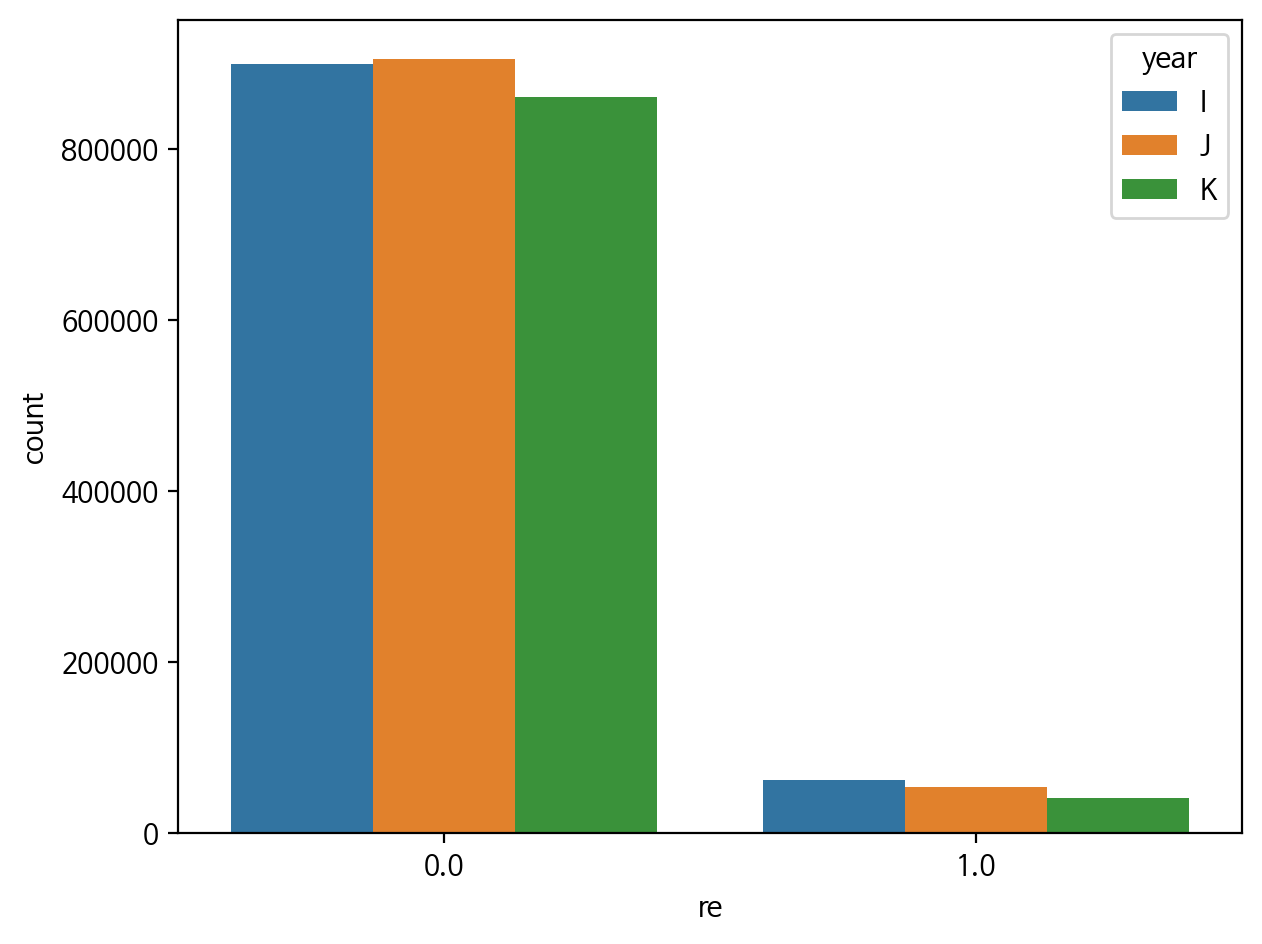

In [53]:
# 0, 1 바이너리 데이터 : nominal data
sns.countplot(data=train_no_outlier_df, x="re", hue="year")
plt.tight_layout()
plt.show()

In [54]:
num_cols

Index(['month', 'time', 'ws10_deg', 'ws10_ms', 'ta', 're', 'hm', 'sun10', 'ts',
       'vis1', 'is_fog', 'dew_point', 'dew_reached', 'temp_diff',
       'diff_z_scores'],
      dtype='object')

In [55]:
str_cols = train_no_outlier_df.select_dtypes(exclude=np.number).columns
str_cols

Index(['year', 'stn_id', 'class'], dtype='object')

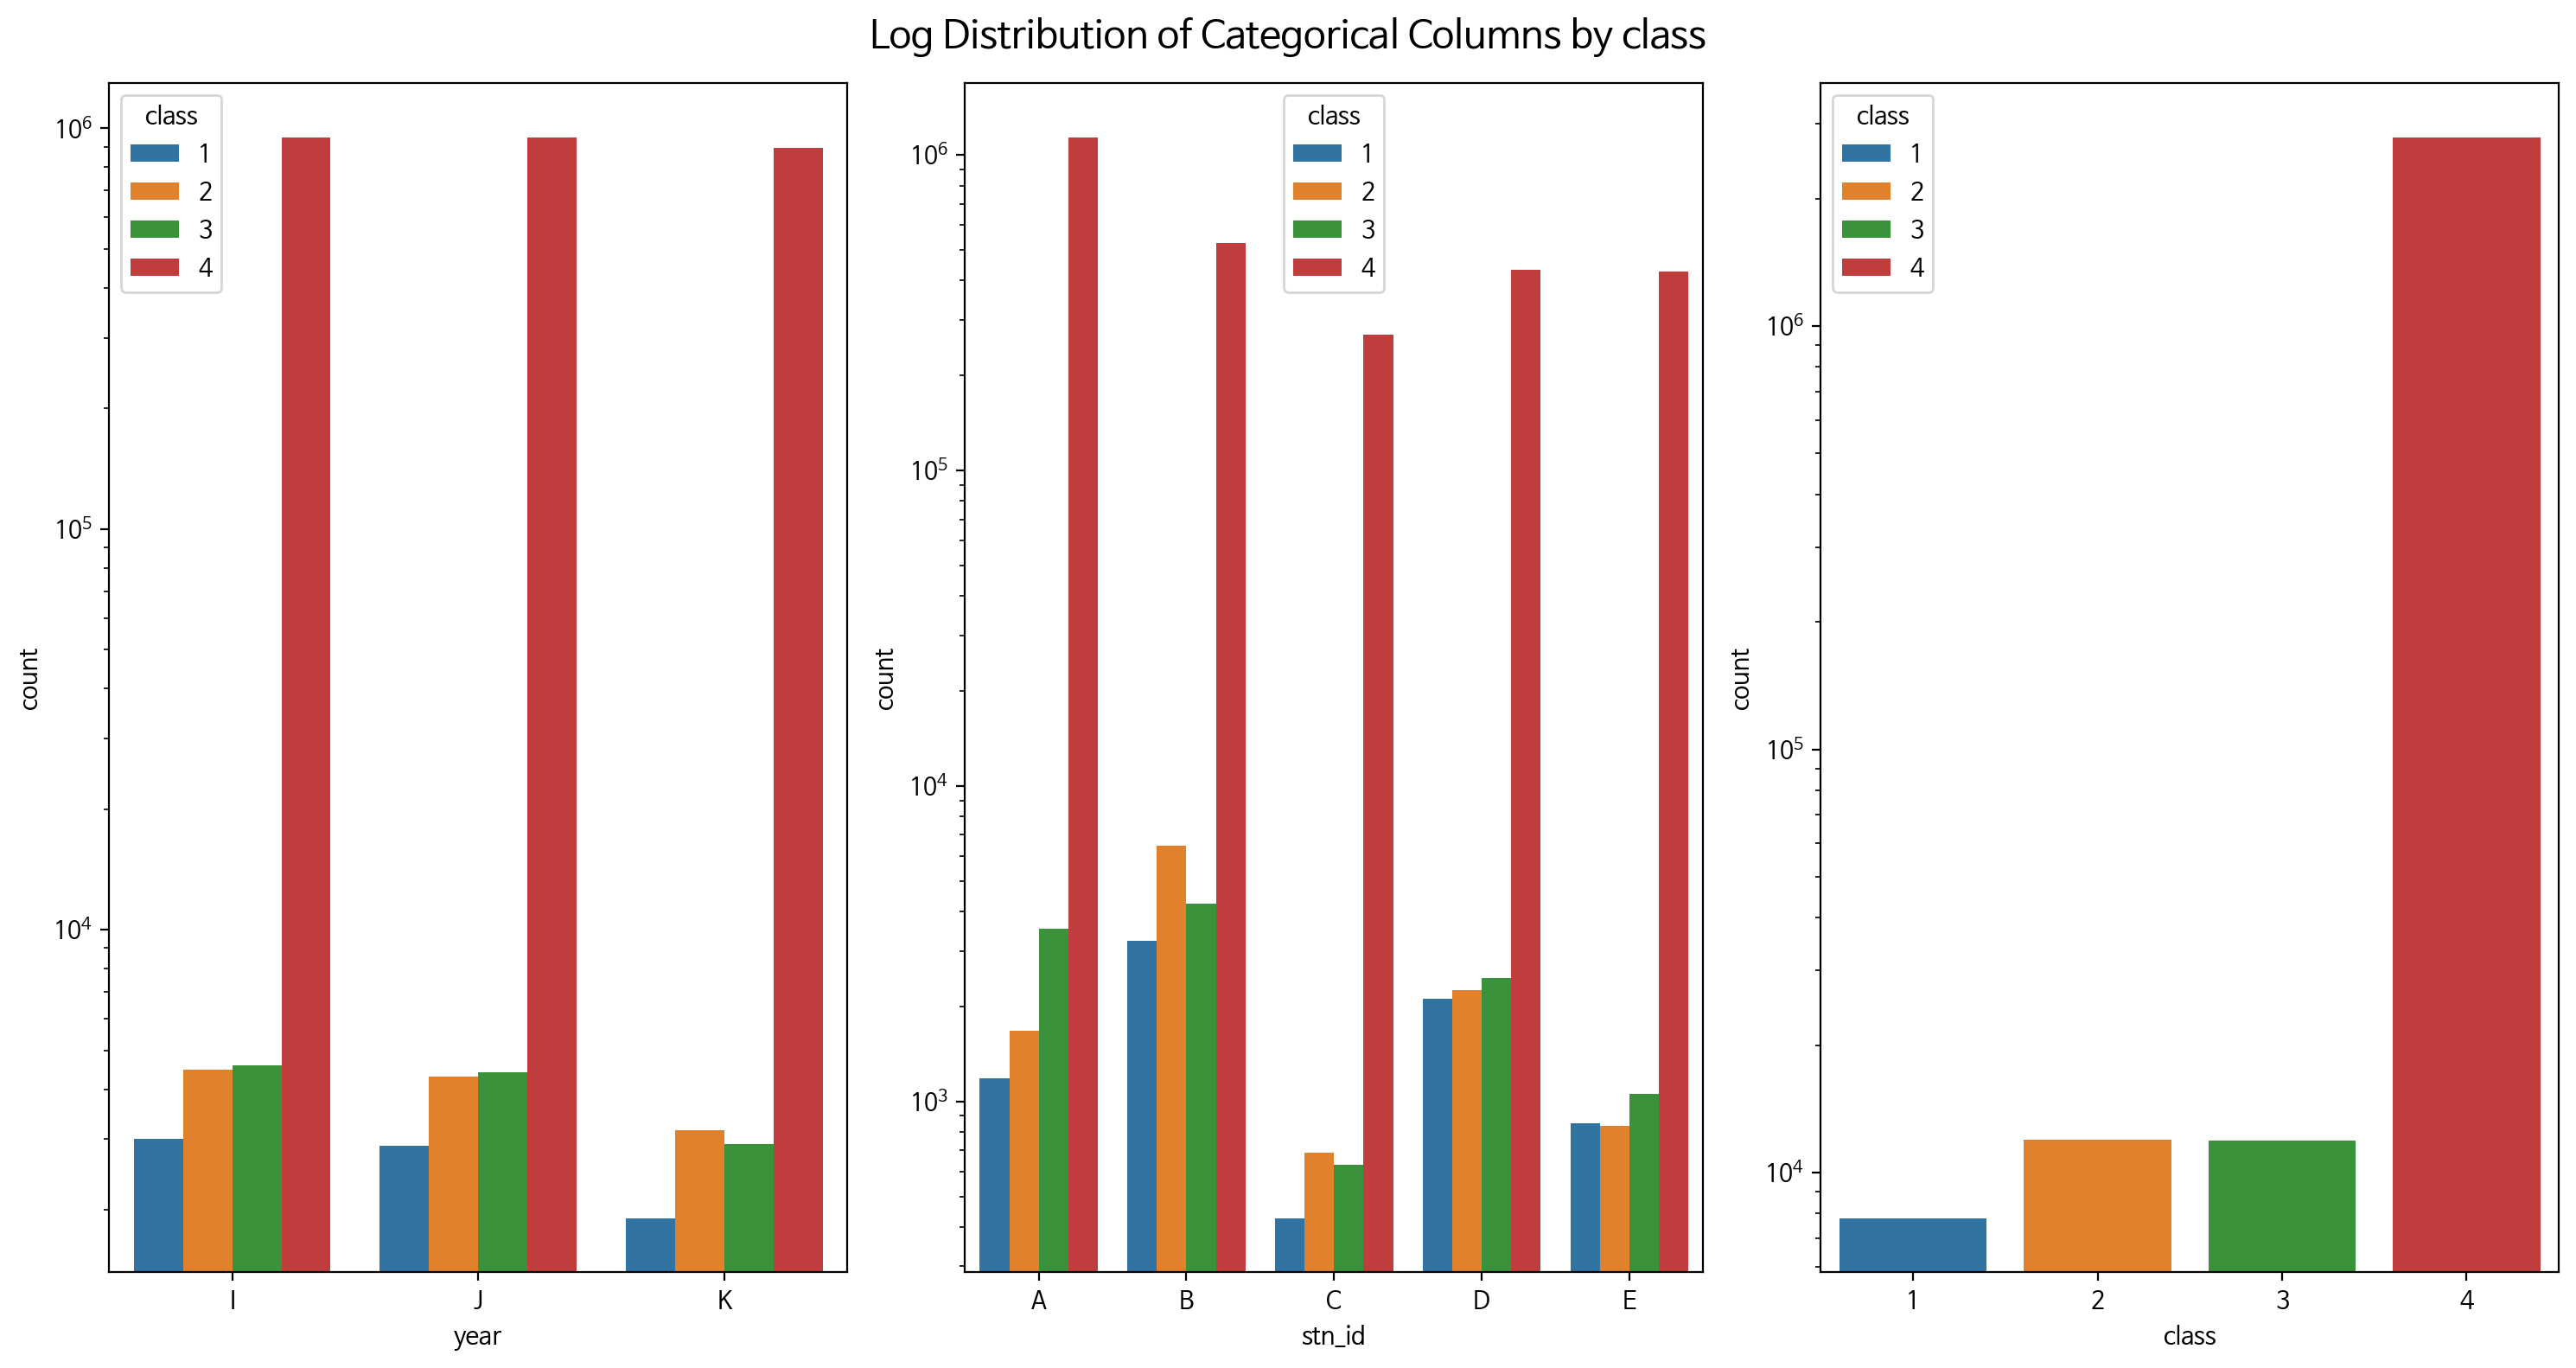

In [56]:
# subplot 생성
nrows, ncols = 1, 3
fig, axes = plt.subplots(nrows, ncols, figsize=(15, 8))

# flatten()을 통해 axes를 1차원 array로 변환
axes = axes.flatten()

for col, ax in zip(str_cols, axes):
    sns.countplot(data=train_no_outlier_df, x=col, ax=ax, hue="class")
    # if col == "class":
    #     sns.countplot(data=train_no_outlier_df, x=col, ax=ax, hue="class")
    # else:
    #     sns.countplot(data=train_no_outlier_df, x=col, ax=ax, hue="class")
    
    # y축을 로그 스케일로 설정
    ax.set_yscale('log')
    # ax.get_yaxis().get_major_formatter().set_scientific(False)

# 빈 subplot 제거
if len(str_cols) < len(axes):
    for i in range(len(str_cols), len(axes)):
        fig.delaxes(axes[i])

fig.suptitle("Log Distribution of Categorical Columns by class", fontsize=16)
fig.tight_layout()
plt.show()


### 4-5. 상관관계 확인

In [57]:
num_cols = train_no_outlier_df.describe().columns
train_df_corr = train_no_outlier_df[num_cols].corr()

train_df_corr.style.background_gradient()

,month,time,ws10_deg,ws10_ms,ta,re,hm,sun10,ts,vis1,is_fog,dew_point,dew_reached,temp_diff,diff_z_scores
month,1.000000,-0.005726,-0.043276,-0.067720,0.206914,-0.013213,0.153272,-0.033682,0.190243,0.098557,0.012465,0.241397,-0.006022,-0.021471,-0.087581
time,-0.005726,1.000000,0.085396,0.119673,0.110356,-0.008064,-0.242420,0.049913,0.107791,0.104611,-0.052547,-0.013268,-0.079340,-0.031134,0.061165
ws10_deg,-0.043276,0.085396,1.000000,0.205448,-0.071683,-0.047899,-0.225204,0.092850,-0.056740,0.032148,-0.021330,-0.157419,-0.036672,-0.021082,0.091430
ws10_ms,-0.067720,0.119673,0.205448,1.000000,-0.003505,0.013928,-0.287200,0.200662,0.037560,0.139378,-0.046652,-0.124325,-0.076540,-0.126520,0.121584
ta,0.206914,0.110356,-0.071683,-0.003505,1.000000,0.061422,0.191090,0.207369,0.949029,0.063001,-0.028596,0.898818,-0.071363,-0.195853,-0.024586
re,-0.013213,-0.008064,-0.047899,0.013928,0.061422,1.000000,0.262068,-0.113408,0.047939,-0.200977,0.067373,0.153242,0.050590,0.020177,-0.148990
hm,0.153272,-0.242420,-0.225204,-0.287200,0.191090,0.262068,1.000000,-0.382240,0.125718,-0.344303,0.131123,0.593416,0.203184,0.135659,-0.402127
sun10,-0.033682,0.049913,0.092850,0.200662,0.207369,-0.113408,-0.382240,1.000000,0.417455,0.144098,-0.051719,-0.001264,-0.106375,-0.727131,0.333047
ts,0.190243,0.107791,-0.056740,0.037560,0.949029,0.047939,0.125718,0.417455,1.000000,0.088556,-0.023179,0.826231,-0.123389,-0.494954,0.025642
vis1,0.098557,0.104611,0.032148,0.139378,0.063001,-0.200977,-0.344303,0.144098,0.088556,1.000000,-0.169989,-0.089917,-0.141720,-0.101840,0.095464


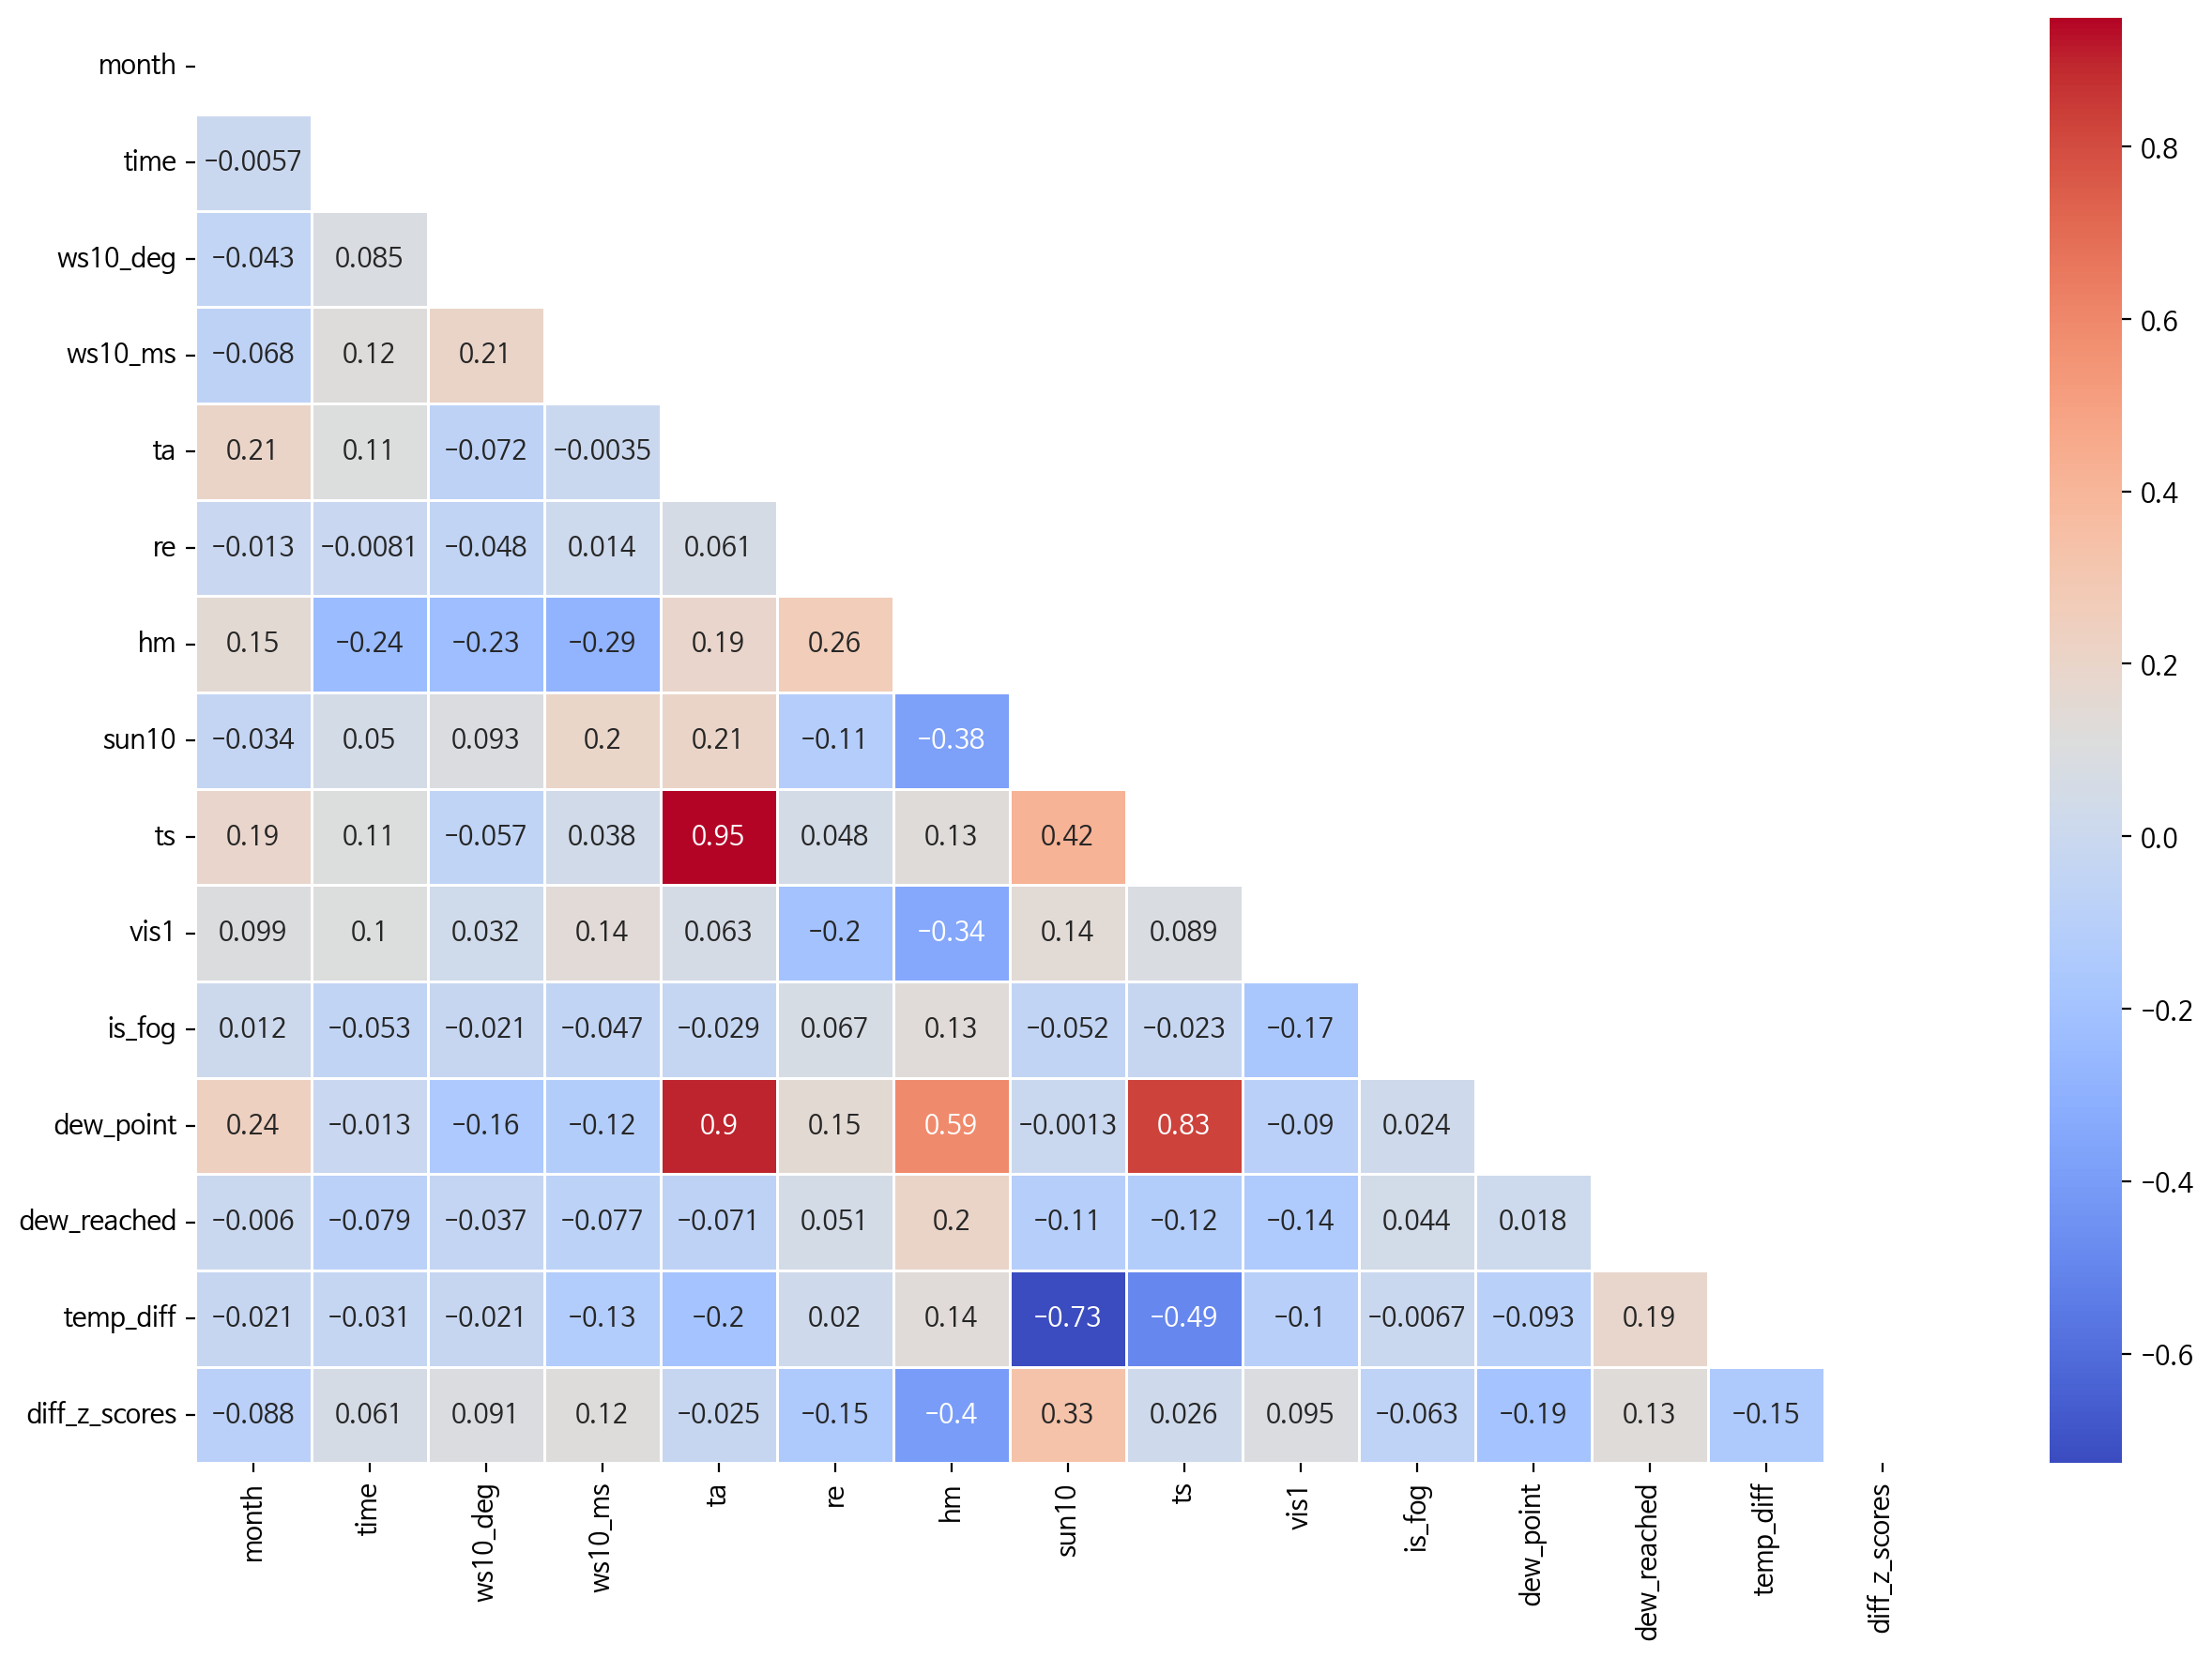

In [58]:
plt.figure(figsize=(15,10))

# 삼각형 마스크를 만든다(위 쪽 삼각형에 True, 아래 삼각형에 False)
mask = np.zeros_like(train_df_corr, dtype=bool)
mask[np.triu_indices_from(mask)] = True

sns.heatmap(train_df_corr,
            annot=True,         # 실제 값을 표시한다
            mask=mask,          # 표시하지 않을 마스크 부분을 지정한다
            linewidths=.5,      # 경계면 실선으로 구분하기
            cmap='coolwarm')
plt.show()

#### 4-5-1. 상관관계 결과
- 강한 양적 선형관계 (0.7 ~ 1.0)
    - `ta` - `ts` : 평균 기온 - 평균 지면온도 (0.95)
    - `ta` - `dew_point` : 평균 기온 - 이슬점 온도 (0.9)
    - `ts` - `dew_point` : 평균 지면 온도 - 이슬점 (0.83) <br>
    <br>
- 뚜렷한 양적 선형관계 (0.3 ~ 0.7)
    - `hm` - `dew_point` : 습도 - 이슬점 (0.59)
    - `sun10` - `ts` : 일사량 - 평균 지면 온도 (0.42)
    - `diff_z_scores` - `sun10` : temp_diff 컬럼의 z-score - 일사량 <br>
    <br>
- 뚜렷한 음적 선형관계 (-0.7 ~ -0.3)
    - `vis1` - `hm` : 평균 시정 - 상대 습도 (-0.34)
    - `hm` - `sum10` : 상대 습도 - 일사량 (-0.38)
    - `hm` - `diff_z_scores` : 상대 습도 - temp_diff 컬럼의 z-score (-0.4)
    - `temp_diff` - `ts` : 기온-지면 온도 차이 - 기온 (-0.49) <br>
    <br>
- 강한 음적 선형관계 (-1.0 ~ -0.7)
    - `sun10` - `temp_diff` : 일사량 - 기온-지면 온도 차이 (-0.73)
